## Deep Learning-Based Energy Disaggregation and Time-Series Analysis for Optimizing Household Appliance Use

#####  Here we apply the LSTM algorithm to predict appliance usage.  The REFIT dataset contains data of 21 houses. We first train, test the model only on data from house 1 and check how well the model performs on the unseen-pattern data of house 2.  

#### Import packages, read house 1 and house 2 data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob


from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
#  file paths for each house
file_paths = ['/Users/eujean/Desktop/FinalProject/data/house_1.csv',
              '/Users/eujean/Desktop/FinalProject/data/house_2.csv']

# read and merge data for each house
def read_merge_data(house):

    df = pd.read_csv(file_paths[house-1])

    # Convert 'unix_time' column to datetime
    df['timestamp'] = pd.to_datetime(df['Unix'], unit='s')
    df.drop(columns=['Time'], inplace=True)


    df.drop(columns=['Unix'], inplace=True)

    # Set 'timestamp' as the index
    df.set_index('timestamp', inplace=True)

    df.dropna(axis=0, how='any', inplace=True)

    return df

# Initialize a dictionary to store DataFrames for each house
dfs = {}

# Iterate over each house and read/merge data
for house in range(1, 3):
    dfs[house] = read_merge_data(house)

for house, df in dfs.items():
    print(f"House {house} DataFrame:")
    print(df.head())
    print("\n")


House 1 DataFrame:
                     Fridge  Television  Microwave
timestamp                                         
2014-03-06 16:23:19     0.0        62.0        2.0
2014-03-06 16:23:33     0.0        63.0        2.0
2014-03-06 16:23:41     0.0        63.0        2.0
2014-03-06 16:23:47     0.0        63.0        2.0
2014-03-06 16:23:55     0.0        62.0        2.0


House 2 DataFrame:
                     Fridge  Television  Microwave
timestamp                                         
2014-03-07 10:33:18   116.0        20.0        1.0
2014-03-07 10:33:32   117.0        20.0        1.0
2014-03-07 10:33:47   116.0        20.0        1.0
2014-03-07 10:34:18   115.0        20.0        1.0
2014-03-07 10:34:33   115.0        20.0        1.0




In [ ]:
for i in range(1, 3):
    print('House {} data has shape: '.format(i), dfs[i].shape)
    display(dfs[i].tail(3))


House 1 data has shape:  (55763, 3)


,Fridge,Television,Microwave
timestamp,,,
2014-03-10 14:40:33,75.0,21.0,2.0
2014-03-10 14:40:46,74.0,21.0,2.0
2014-03-10 14:40:47,74.0,21.0,2.0


House 2 data has shape:  (53838, 3)


,Fridge,Television,Microwave
timestamp,,,
2014-03-11 05:28:48,9.0,25.0,1.0
2014-03-11 05:28:58,9.0,24.0,1.0
2014-03-11 05:29:02,9.0,24.0,1.0


In [ ]:
dates = {}
for i in range(1, 3):  # Iterate over each house

    dates[i] = [str(time)[:10] for time in dfs[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i, len(dates[i]), dates[i][0], dates[i][-1]))
    print(dates[i], '\n')


House 1 data contain 5 days from 2014-03-06 to 2014-03-10.
['2014-03-06', '2014-03-07', '2014-03-08', '2014-03-09', '2014-03-10'] 

House 2 data contain 5 days from 2014-03-07 to 2014-03-11.
['2014-03-07', '2014-03-08', '2014-03-09', '2014-03-10', '2014-03-11'] 



House 1 DataFrame Index:
DatetimeIndex(['2014-03-06 16:23:19', '2014-03-06 16:23:33',
               '2014-03-06 16:23:41', '2014-03-06 16:23:47',
               '2014-03-06 16:23:55', '2014-03-06 16:24:02',
               '2014-03-06 16:24:09', '2014-03-06 16:24:16',
               '2014-03-06 16:24:19', '2014-03-06 16:24:24',
               ...
               '2014-03-10 14:40:00', '2014-03-10 14:40:03',
               '2014-03-10 14:40:15', '2014-03-10 14:40:17',
               '2014-03-10 14:40:18', '2014-03-10 14:40:29',
               '2014-03-10 14:40:32', '2014-03-10 14:40:33',
               '2014-03-10 14:40:46', '2014-03-10 14:40:47'],
              dtype='datetime64[ns]', name='timestamp', length=55763, freq=None)


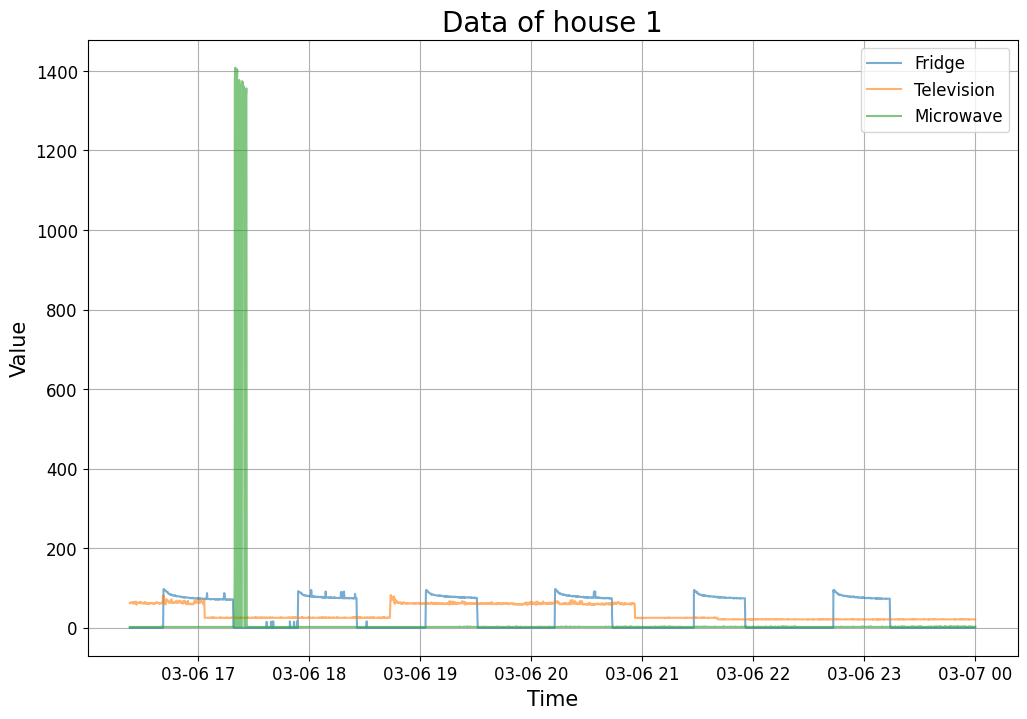

House 2 DataFrame Index:
DatetimeIndex(['2014-03-07 10:33:18', '2014-03-07 10:33:32',
               '2014-03-07 10:33:47', '2014-03-07 10:34:18',
               '2014-03-07 10:34:33', '2014-03-07 10:34:47',
               '2014-03-07 10:35:01', '2014-03-07 10:35:15',
               '2014-03-07 10:35:19', '2014-03-07 10:35:30',
               ...
               '2014-03-11 05:28:13', '2014-03-11 05:28:16',
               '2014-03-11 05:28:19', '2014-03-11 05:28:27',
               '2014-03-11 05:28:30', '2014-03-11 05:28:34',
               '2014-03-11 05:28:44', '2014-03-11 05:28:48',
               '2014-03-11 05:28:58', '2014-03-11 05:29:02'],
              dtype='datetime64[ns]', name='timestamp', length=53838, freq=None)


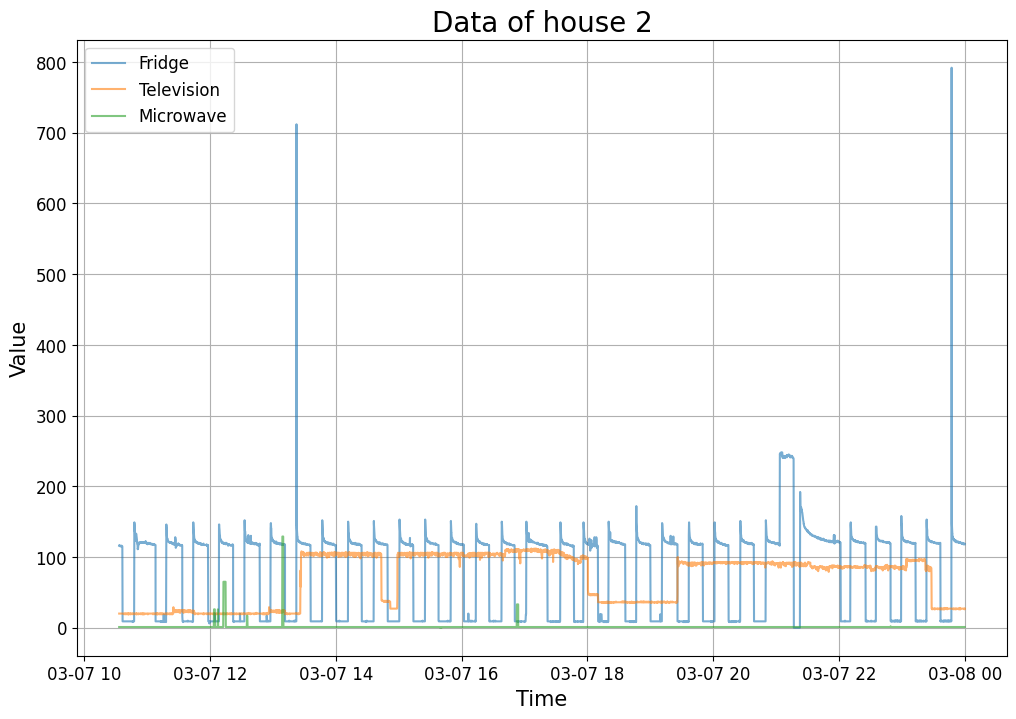

In [ ]:
# Plot the first 2 days of data for each house
for i in range(1, 3):
    # Sort the DataFrame index
    sorted_df = dfs[i].sort_index()

    # Print the DataFrame index for debugging
    print("House", i, "DataFrame Index:")
    print(sorted_df.index)

    # Extract the first two days of data
    start_date = dates[i][0]
    end_date = pd.to_datetime(start_date) + pd.Timedelta(days=1)
    plot_df(sorted_df.loc[start_date:end_date], 'Data of house {}'.format(i))


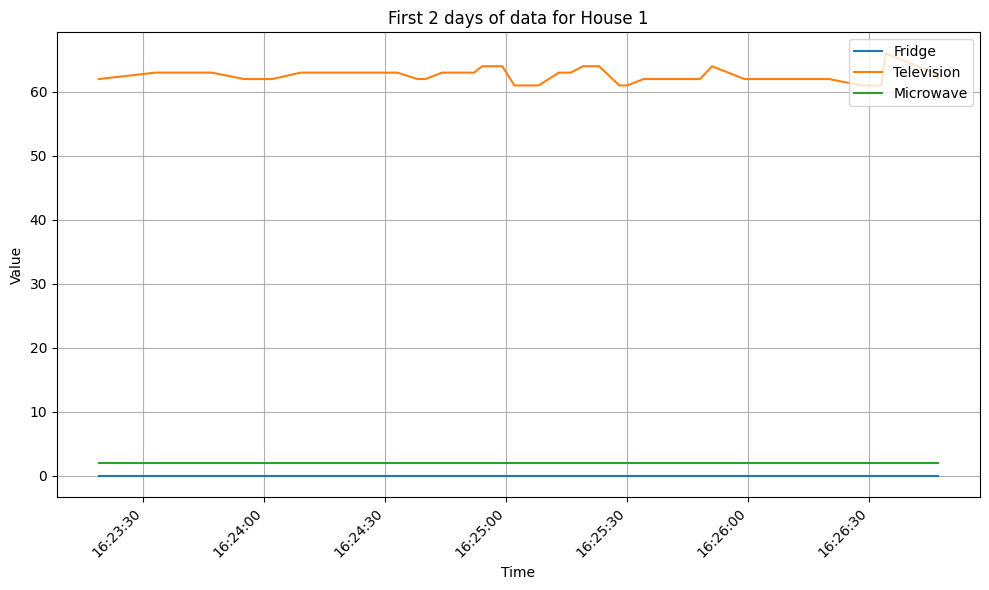

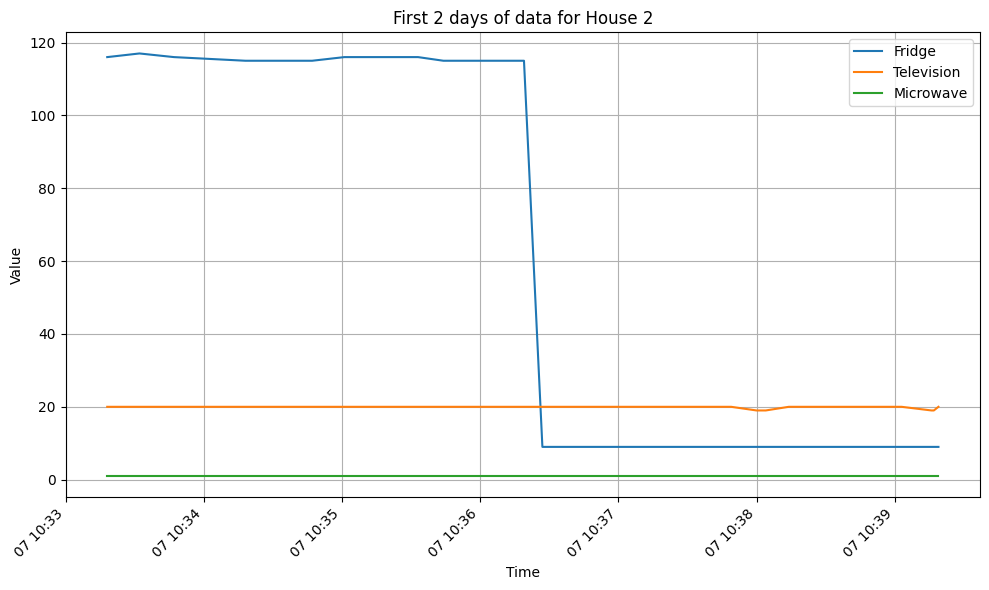

In [ ]:
import matplotlib.pyplot as plt

# Define the plot_df function
def plot_df(df, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    df.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the first 2 days of data for each house
for house, df in dfs.items():
    title = f"First 2 days of data for House {house}"
    plot_df(df.iloc[:48], title)


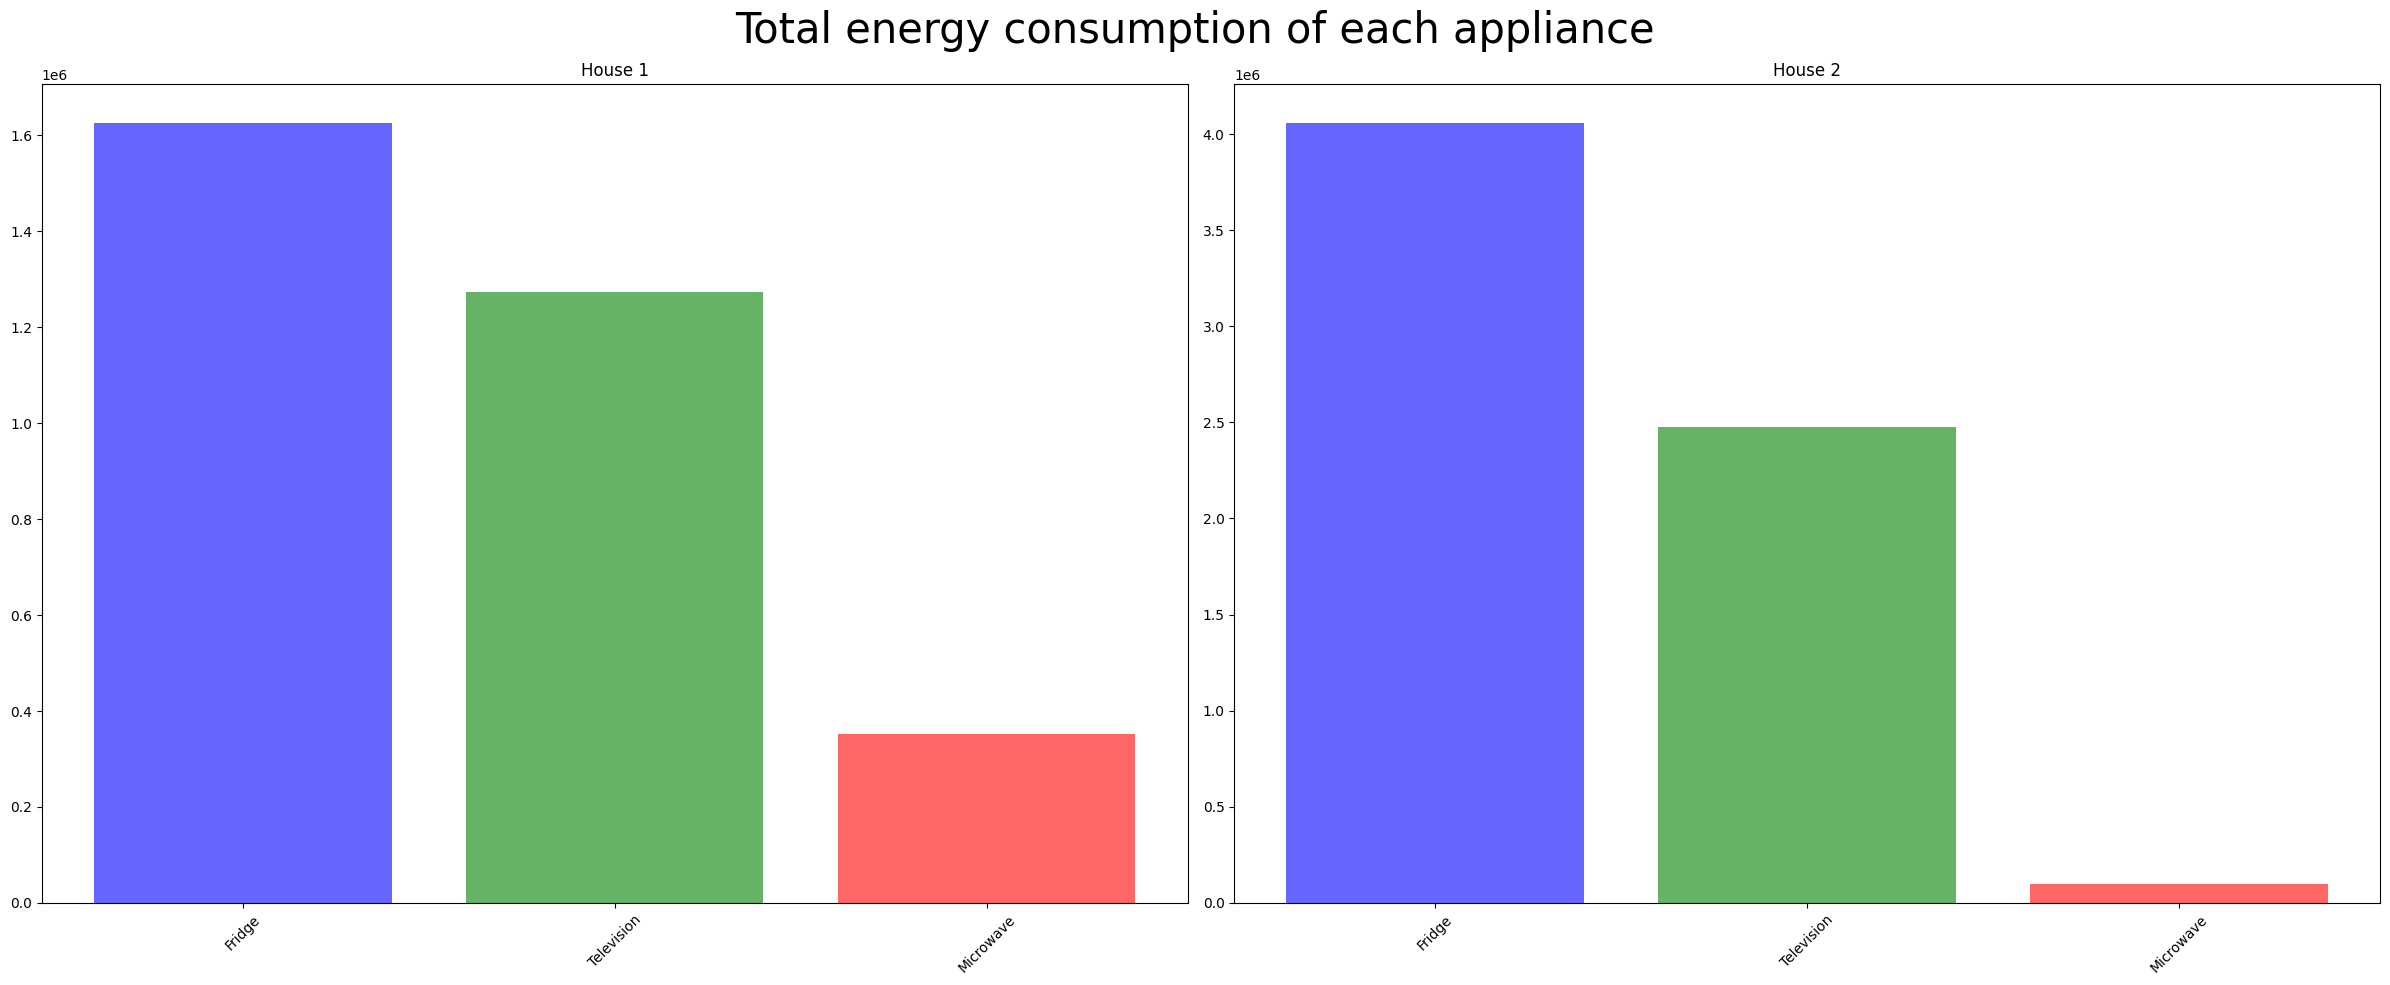

In [ ]:
colors = ['b', 'g', 'r']

# Plot total energy consumption of each appliance from all houses
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
plt.suptitle('Total energy consumption of each appliance', fontsize=30)

for house, df in dfs.items():
    cons = df[df.columns.values[0:]].sum().sort_values(ascending=False)
    app = cons.index
    y_pos = np.arange(len(app))
    axes[house - 1].bar(y_pos, cons.values, alpha=0.6, color=colors[:len(app)])
    axes[house - 1].set_xticks(y_pos)
    axes[house - 1].set_xticklabels(app, rotation=45)
    axes[house - 1].set_title(f'House {house}')

plt.tight_layout()
plt.show()

## Data Preparation for LSTM Prediction Model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define the proportions for train and test sets
train_ratio = 0.7
test_ratio = 0.3

# Initialize dictionaries to store train and test DataFrames for each house
train_data = {}
test_data = {}

# Split the data for each house
for house, df in dfs.items():
    total_samples = len(df)
    train_size = int(total_samples * train_ratio)
    test_size = total_samples - train_size

    # Split the data
    train_data[house] = df.iloc[:train_size]
    test_data[house] = df.iloc[train_size:]



In [ ]:
for house in range(1, 3):
    print(f"House {house}:")
    print(f"Train set length: {len(train_data[house])}")
    print(f"Test set length: {len(test_data[house])}")
    print()

House 1:
Train set length: 39034
Test set length: 16729

House 2:
Train set length: 37686
Test set length: 16152



In [ ]:
# prepare data for LSTM
def prepare_lstm_data(df):

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)

    # Prepare the data in sequences for LSTM
    X = []
    y = []
    for i in range(len(scaled_data)):
        end_ix = i + 1
        if end_ix > len(scaled_data)-1:
            break
        seq_x, seq_y = scaled_data[i:end_ix], scaled_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), scaler

# Initialize dictionaries to store prepared data and scalers for each house
train_X, train_y, train_scalers = {}, {}, {}
test_X, test_y, test_scalers = {}, {}, {}

# Prepare the data for each house
for house in range(1, 4):

    # training data
    train_X[house], train_y[house], train_scalers[house] = prepare_lstm_data(train_data[house])

    # testing data
    test_X[house], test_y[house], test_scalers[house] = prepare_lstm_data(test_data[house])

## Vanilla LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Define LSTM model architecture
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=64, input_shape=input_shape),
        Dense(units=3)
    ])
    return model

model = build_lstm_model(input_shape=(train_X[1].shape[1], train_X[1].shape[2]))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 17603 (68.76 KB)
Trainable params: 17603 (68.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Vanilla LSTM model architecture

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=64, input_shape=input_shape),
        Dense(units=3)
    ])
    return model

model = build_lstm_model(input_shape=(train_X[1].shape[1], train_X[1].shape[2]))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 17603 (68.76 KB)
Trainable params: 17603 (68.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

# Define the learning rate
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

# Compile the vanilla LSTM model
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])



In [ ]:


# Train the model

history = model.fit(train_X[1], train_y[1], epochs=100, batch_size=32, validation_data=(test_X[1], test_y[1]))



Epoch 1/100
1220/1220 [==============================] - 7s 4ms/step - loss: 0.0011 - accuracy: 0.9956 - val_loss: 0.0142 - val_accuracy: 0.9903
Epoch 2/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1400e-04 - accuracy: 0.9988 - val_loss: 0.0141 - val_accuracy: 0.9903
Epoch 3/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1431e-04 - accuracy: 0.9988 - val_loss: 0.0142 - val_accuracy: 0.9903
Epoch 4/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1530e-04 - accuracy: 0.9988 - val_loss: 0.0139 - val_accuracy: 0.9903
Epoch 5/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1399e-04 - accuracy: 0.9988 - val_loss: 0.0141 - val_accuracy: 0.9903
Epoch 6/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1317e-04 - accuracy: 0.9988 - val_loss: 0.0138 - val_accuracy: 0.9903
Epoch 7/100
1220/1220 [==============================] - 3s 3ms/step - loss: 3.0861e-04 - accuracy: 0.9988 - v

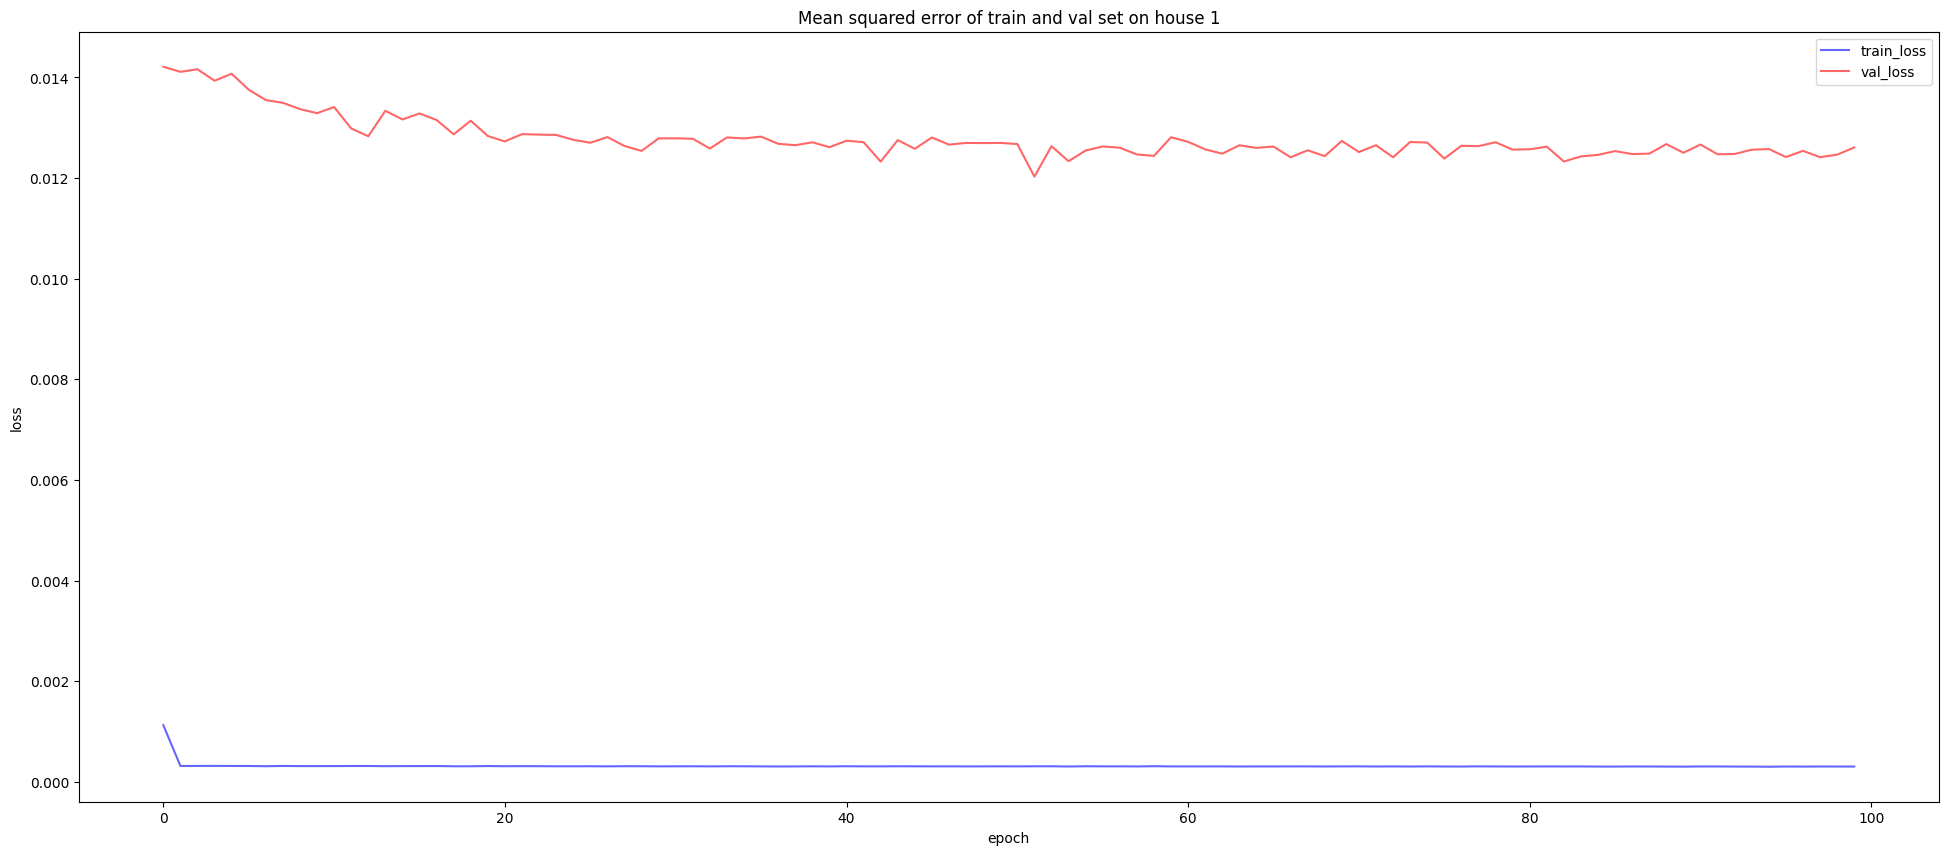

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

In [ ]:
# Save the model
model.save('lstm_model.h5')


In [ ]:
# Evaluataccuracye the model on test data
loss, accuracy = model.evaluate(train_X[1], train_y[1])
print("Test Loss:", loss)
print("Train Accuracy: ", accuracy)

1220/1220 [==============================] - 2s 2ms/step - loss: 2.7908e-04 - accuracy: 0.9989
Test Loss: 0.0002790806465782225
Train Accuracy:  0.9989240169525146


In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_X[1], test_y[1])
print("Test Loss:", loss)
print("Test Accuracy: ", accuracy)

523/523 [==============================] - 1s 2ms/step - loss: 0.0126 - accuracy: 0.9872
Test Loss: 0.012609352357685566
Test Accuracy:  0.9872070550918579


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Predict energy consumption using the trained LSTM model
predictions = model.predict(test_X[1])

# Inverse transform the predictions to get the original scale of energy consumption
predictions = test_scalers[1].inverse_transform(predictions)

# Inverse transform the actual values to get the original scale of energy consumption
actual_values = test_scalers[1].inverse_transform(test_y[1])



mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y[1], predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

523/523 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 641.1797433427927
Root Mean Squared Error (RMSE): 25.321527271134194
Mean Absolute Error (MAE): 19.39890126994199


In [ ]:
# Fridge


timestamp_index = test_data[1].index[:len(predictions)]

fridge_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 0],
    'Predicted Values': predictions[:, 0]
})


print("Fridge:")
print(fridge_output.head(20))


Fridge:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13           73.0         73.184326
1  2014-03-09 10:13:15           73.0         72.218887
2  2014-03-09 10:13:20           73.0         72.218887
3  2014-03-09 10:13:27           73.0         72.218887
4  2014-03-09 10:13:29           74.0         72.218887
5  2014-03-09 10:13:34           73.0         73.184326
6  2014-03-09 10:13:43           74.0         72.218887
7  2014-03-09 10:13:48           72.0         73.184326
8  2014-03-09 10:13:57           72.0         71.252457
9  2014-03-09 10:14:02           74.0         71.252457
10 2014-03-09 10:14:12           73.0         73.184326
11 2014-03-09 10:14:16           73.0         72.218887
12 2014-03-09 10:14:19           73.0         72.218887
13 2014-03-09 10:14:26           74.0         72.218887
14 2014-03-09 10:14:31           74.0         73.184326
15 2014-03-09 10:14:33           74.0         73.184326
16 2014-03-09 10:14:45           73.0   

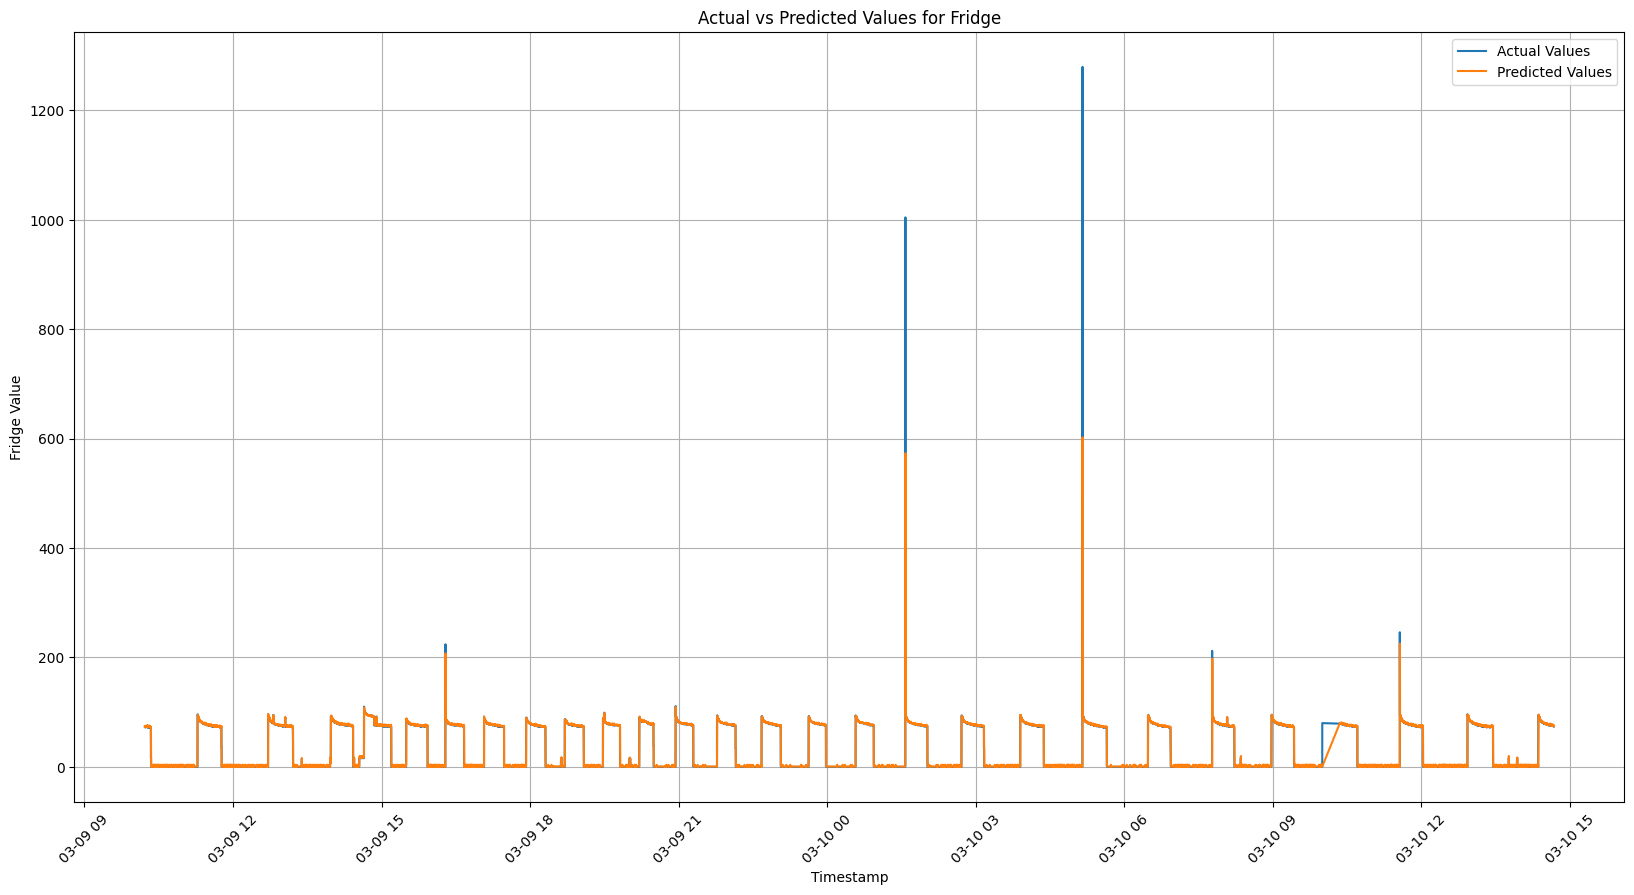

In [ ]:
# Plot actual vs predicted values for Fridge

plt.figure(figsize=(20, 10))
plt.plot(fridge_output['Timestamp'], fridge_output['Actual Values'], label='Actual Values')
plt.plot(fridge_output['Timestamp'], fridge_output['Predicted Values'], label='Predicted Values')
plt.title('Actual vs Predicted Values for Fridge')
plt.xlabel('Timestamp')
plt.ylabel('Fridge Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Television

timestamp_index = test_data[1].index[:len(predictions)]


tv_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 1],
    'Predicted Values': predictions[:, 1]
})


print("Television:")
print(tv_output.head(20))


Television:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13           21.0         21.020546
1  2014-03-09 10:13:15           21.0         21.020552
2  2014-03-09 10:13:20           21.0         21.020552
3  2014-03-09 10:13:27           21.0         21.020552
4  2014-03-09 10:13:29           21.0         21.020552
5  2014-03-09 10:13:34           21.0         21.020546
6  2014-03-09 10:13:43           21.0         21.020552
7  2014-03-09 10:13:48           21.0         21.020546
8  2014-03-09 10:13:57           21.0         21.020557
9  2014-03-09 10:14:02           21.0         21.020557
10 2014-03-09 10:14:12           21.0         21.020546
11 2014-03-09 10:14:16           21.0         21.020552
12 2014-03-09 10:14:19           21.0         21.020552
13 2014-03-09 10:14:26           21.0         21.020552
14 2014-03-09 10:14:31           21.0         21.020546
15 2014-03-09 10:14:33           21.0         21.020546
16 2014-03-09 10:14:45           21.

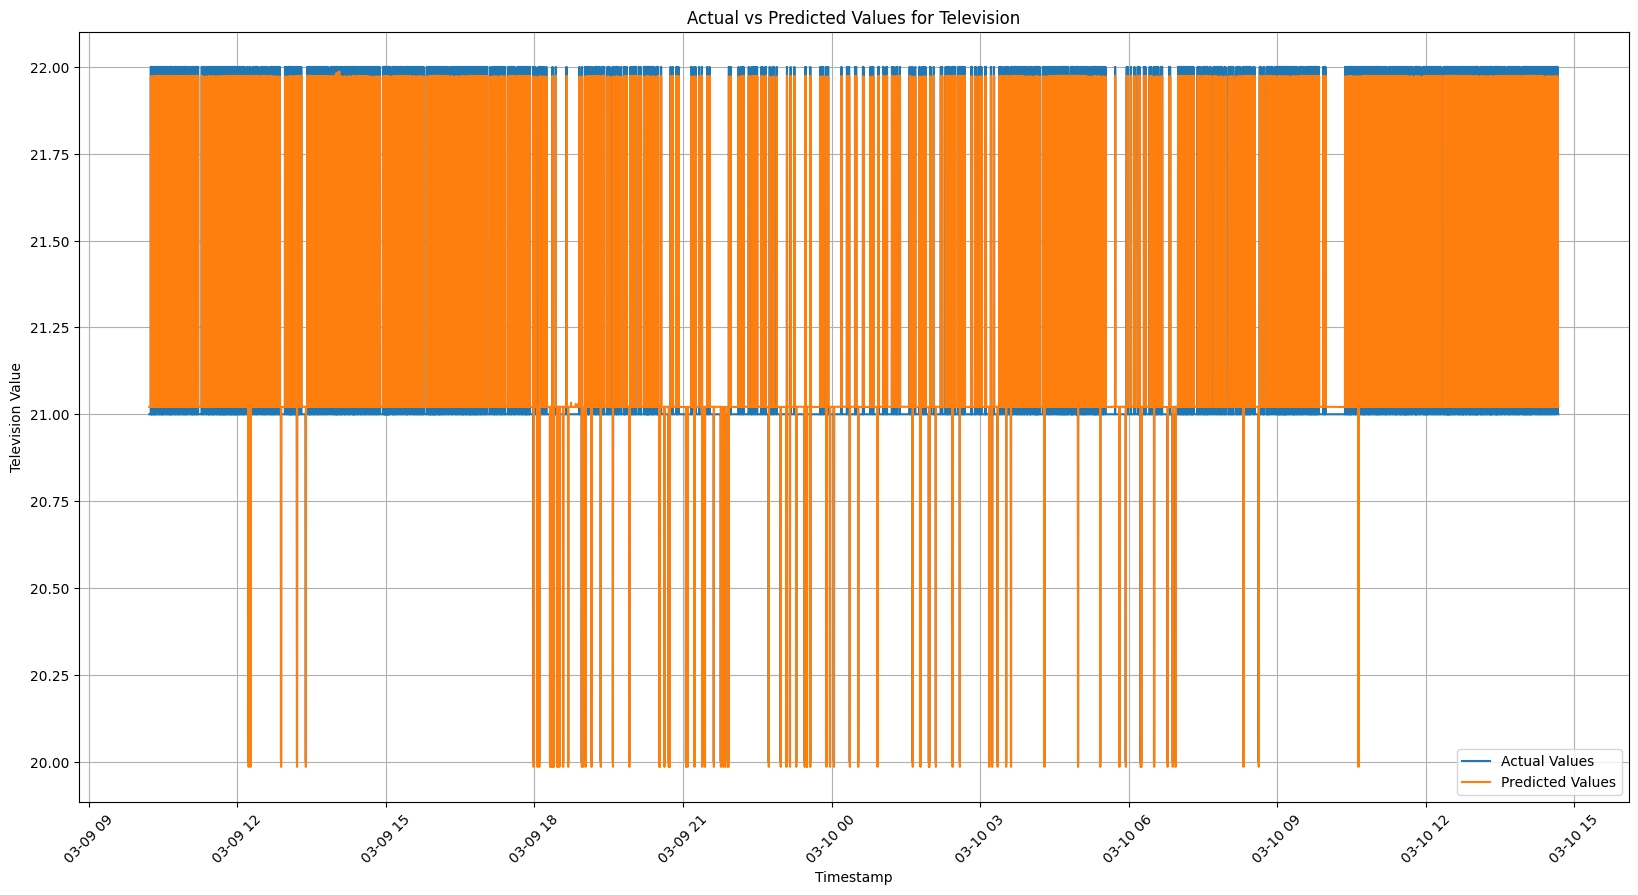

In [ ]:

# Plot actual vs predicted values for Television

plt.figure(figsize=(20, 10))
plt.plot(tv_output['Timestamp'], tv_output['Actual Values'], label='Actual Values')
plt.plot(tv_output['Timestamp'], tv_output['Predicted Values'], label='Predicted Values')
plt.title('Actual vs Predicted Values for Television')
plt.xlabel('Timestamp')
plt.ylabel('Television Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# Microwave

timestamp_index = test_data[1].index[:len(predictions)]


microwave_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 2],
    'Predicted Values': predictions[:, 2]
})

print("Microwave:")
print(microwave_output.head(20))


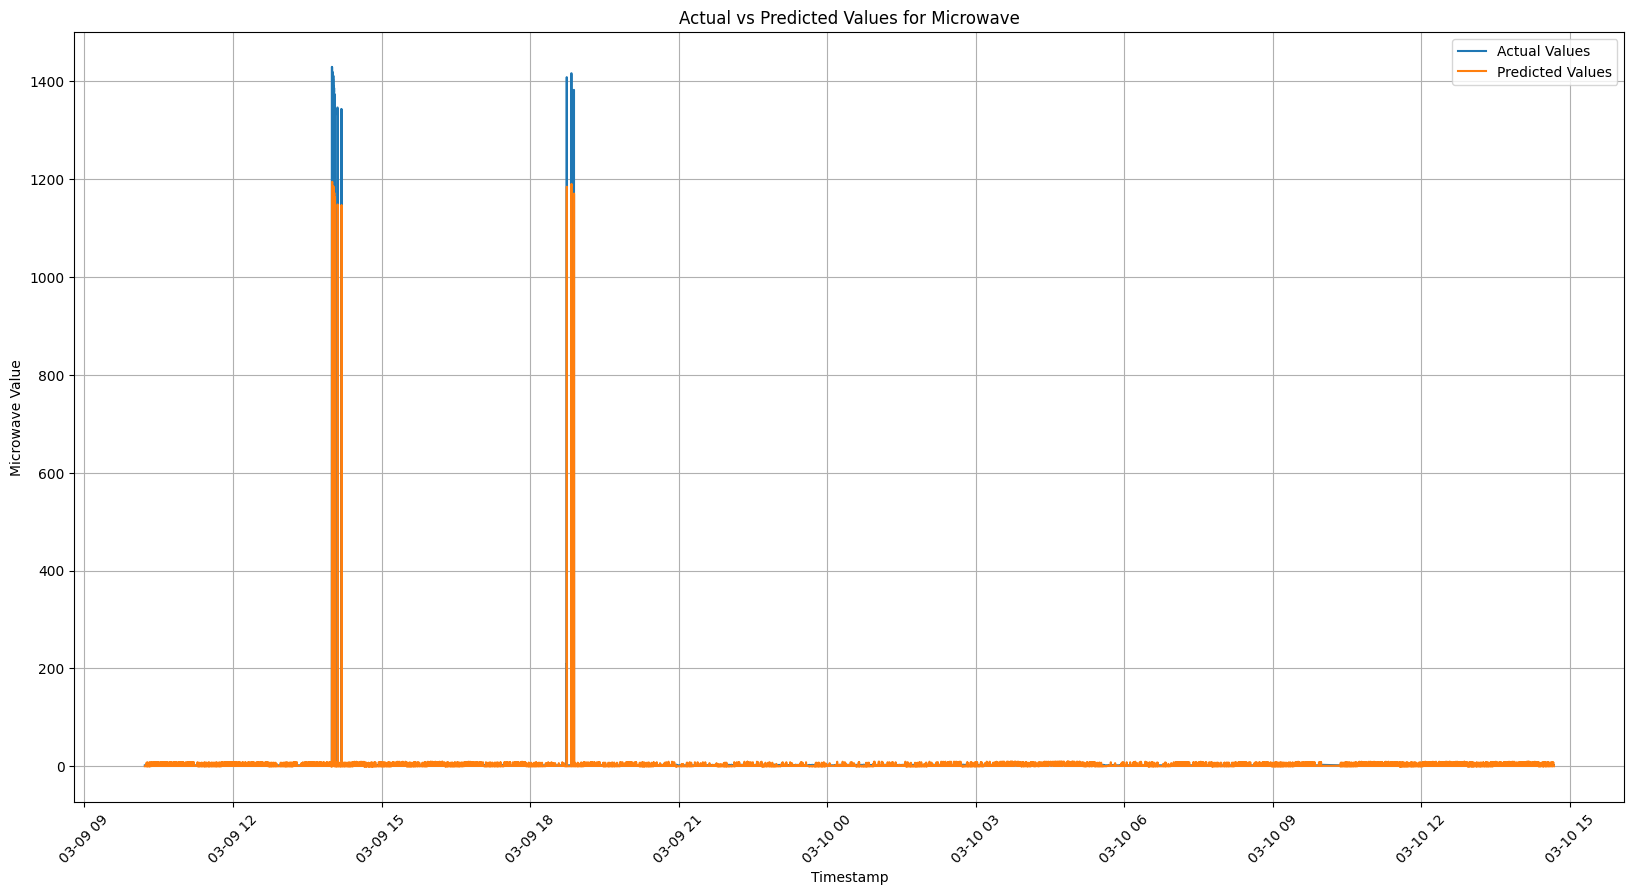

In [ ]:
# Plot actual vs predicted values for Microwave

plt.figure(figsize=(20, 10))
plt.plot(microwave_output['Timestamp'], microwave_output['Actual Values'], label='Actual Values')
plt.plot(microwave_output['Timestamp'], microwave_output['Predicted Values'], label='Predicted Values')
plt.title('Actual vs Predicted Values for Microwave')
plt.xlabel('Timestamp')
plt.ylabel('Microwave Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Using the vanilla LSTM model we have just trained on house 1 to predict energy consumtion on house 2

In [ ]:
# Load and preprocess data for house 2
house_2_data = read_merge_data(2)
house_2_X, house_2_y, house_2_scaler = prepare_lstm_data(house_2_data)



# Predict energy consumption for house 2 using the Vanilla trained model on house 1
house_2_predictions = model.predict(house_2_X)



# Inverse transform the predictions to get the original scale of energy consumption
house_2_predictions = house_2_scaler.inverse_transform(house_2_predictions)

house_2_y = house_2_scaler.inverse_transform(house_2_y)



mse_house_2 = mean_squared_error(house_2_y, house_2_predictions)
rmse_house_2 = np.sqrt(mse_house_2)
mae_house_2 = mean_absolute_error(house_2_y, house_2_predictions)

print("House 2 Prediction Metrics:")
print("Mean Squared Error (MSE):", mse_house_2)
print("Root Mean Squared Error (RMSE):", rmse_house_2)
print("Mean Absolute Error (MAE):", mae_house_2)


1683/1683 [==============================] - 3s 2ms/step
House 2 Prediction Metrics:
Mean Squared Error (MSE): 272.9274841875866
Root Mean Squared Error (RMSE): 16.520517067803496
Mean Absolute Error (MAE): 2.55906810800114


In [ ]:
# Determine the minimum length among timestamp_index, house_2_y, and house_2_predictions
min_length = min(len(timestamp_index), len(house_2_y), len(house_2_predictions))



# Slice the arrays to match the minimum length
timestamp_index = timestamp_index[:min_length]
house_2_y = house_2_y[:min_length]
house_2_predictions = house_2_predictions[:min_length]




fridge_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': house_2_y[:, 0],
    'Predicted Values': house_2_predictions[:, 0]
})

# Print the DataFrame for the Microwave appliance
print("Fridge:")
print(fridge_output.head(15))


Fridge:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13          117.0        113.591240
1  2014-03-09 10:13:15          116.0        114.509796
2  2014-03-09 10:13:20          115.0        113.591240
3  2014-03-09 10:13:27          115.0        112.671700
4  2014-03-09 10:13:29          115.0        112.671700
5  2014-03-09 10:13:34          116.0        112.671700
6  2014-03-09 10:13:43          116.0        113.591240
7  2014-03-09 10:13:48          116.0        113.591240
8  2014-03-09 10:13:57          116.0        113.591240
9  2014-03-09 10:14:02          116.0        113.591240
10 2014-03-09 10:14:12          115.0        113.591240
11 2014-03-09 10:14:16          115.0        112.671700
12 2014-03-09 10:14:19          115.0        112.671700
13 2014-03-09 10:14:26          115.0        112.671700
14 2014-03-09 10:14:31          115.0        112.671700


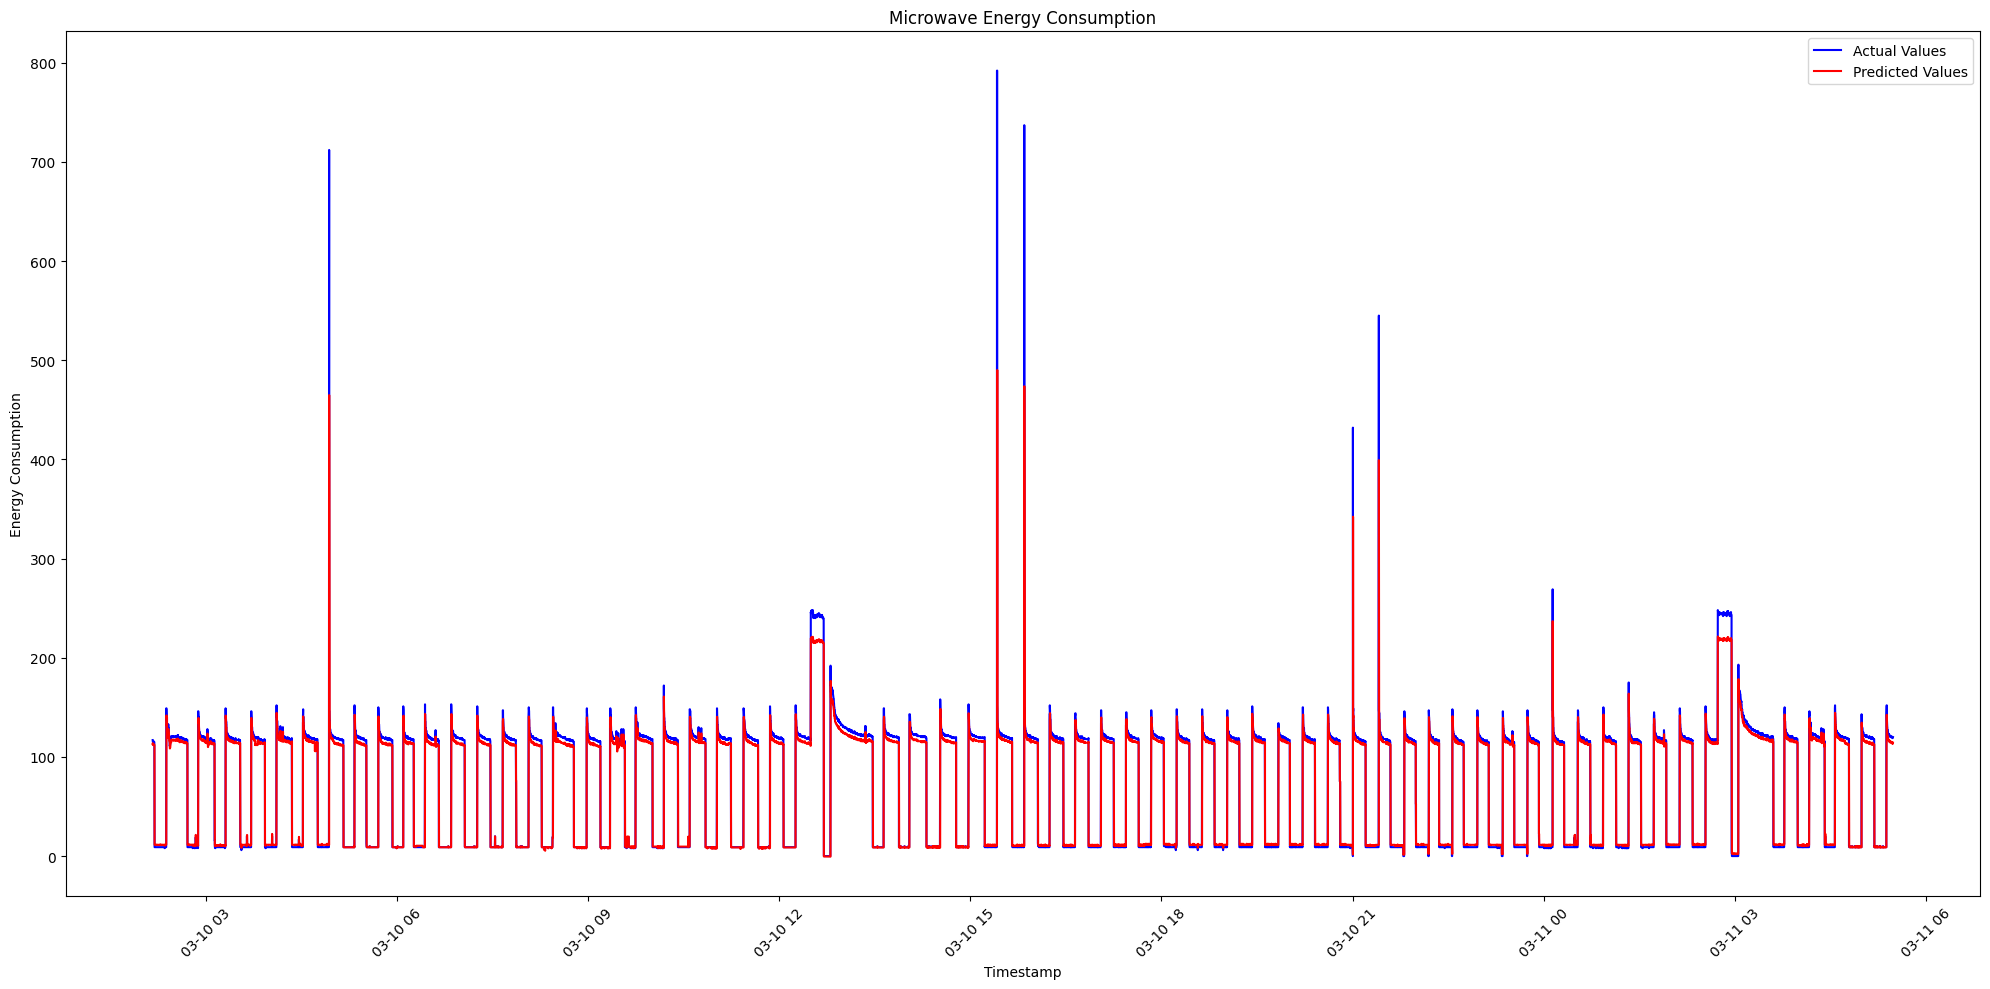

In [ ]:
import matplotlib.pyplot as plt

# Plot actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(fridge_output['Timestamp'], fridge_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(fridge_output['Timestamp'], fridge_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
min_length = min(len(timestamp_index), len(house_2_y), len(house_2_predictions))

# Slice the arrays to match the minimum length
timestamp_index = timestamp_index[:min_length]
house_2_y = house_2_y[:min_length]
house_2_predictions = house_2_predictions[:min_length]



tv_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': house_2_y[:, 1],
    'Predicted Values': house_2_predictions[:, 1]
})


print("Television:")
print(tv_output.head(20))


Television:
             Timestamp  Actual Values  Predicted Values
0  2014-03-10 02:09:45           20.0         20.592707
1  2014-03-10 02:09:48           20.0         20.592434
2  2014-03-10 02:09:59           20.0         20.592707
3  2014-03-10 02:10:02           20.0         20.592979
4  2014-03-10 02:10:14           20.0         20.592979
5  2014-03-10 02:10:16           20.0         20.592979
6  2014-03-10 02:10:18           20.0         20.592707
7  2014-03-10 02:10:28           20.0         20.592707
8  2014-03-10 02:10:31           20.0         20.592707
9  2014-03-10 02:10:33           20.0         20.592707
10 2014-03-10 02:10:45           20.0         20.592707
11 2014-03-10 02:10:47           20.0         20.592979
12 2014-03-10 02:10:59           20.0         20.592979
13 2014-03-10 02:11:01           20.0         20.592979
14 2014-03-10 02:11:13           20.0         20.592979
15 2014-03-10 02:11:16           20.0         20.592979
16 2014-03-10 02:11:19           20.

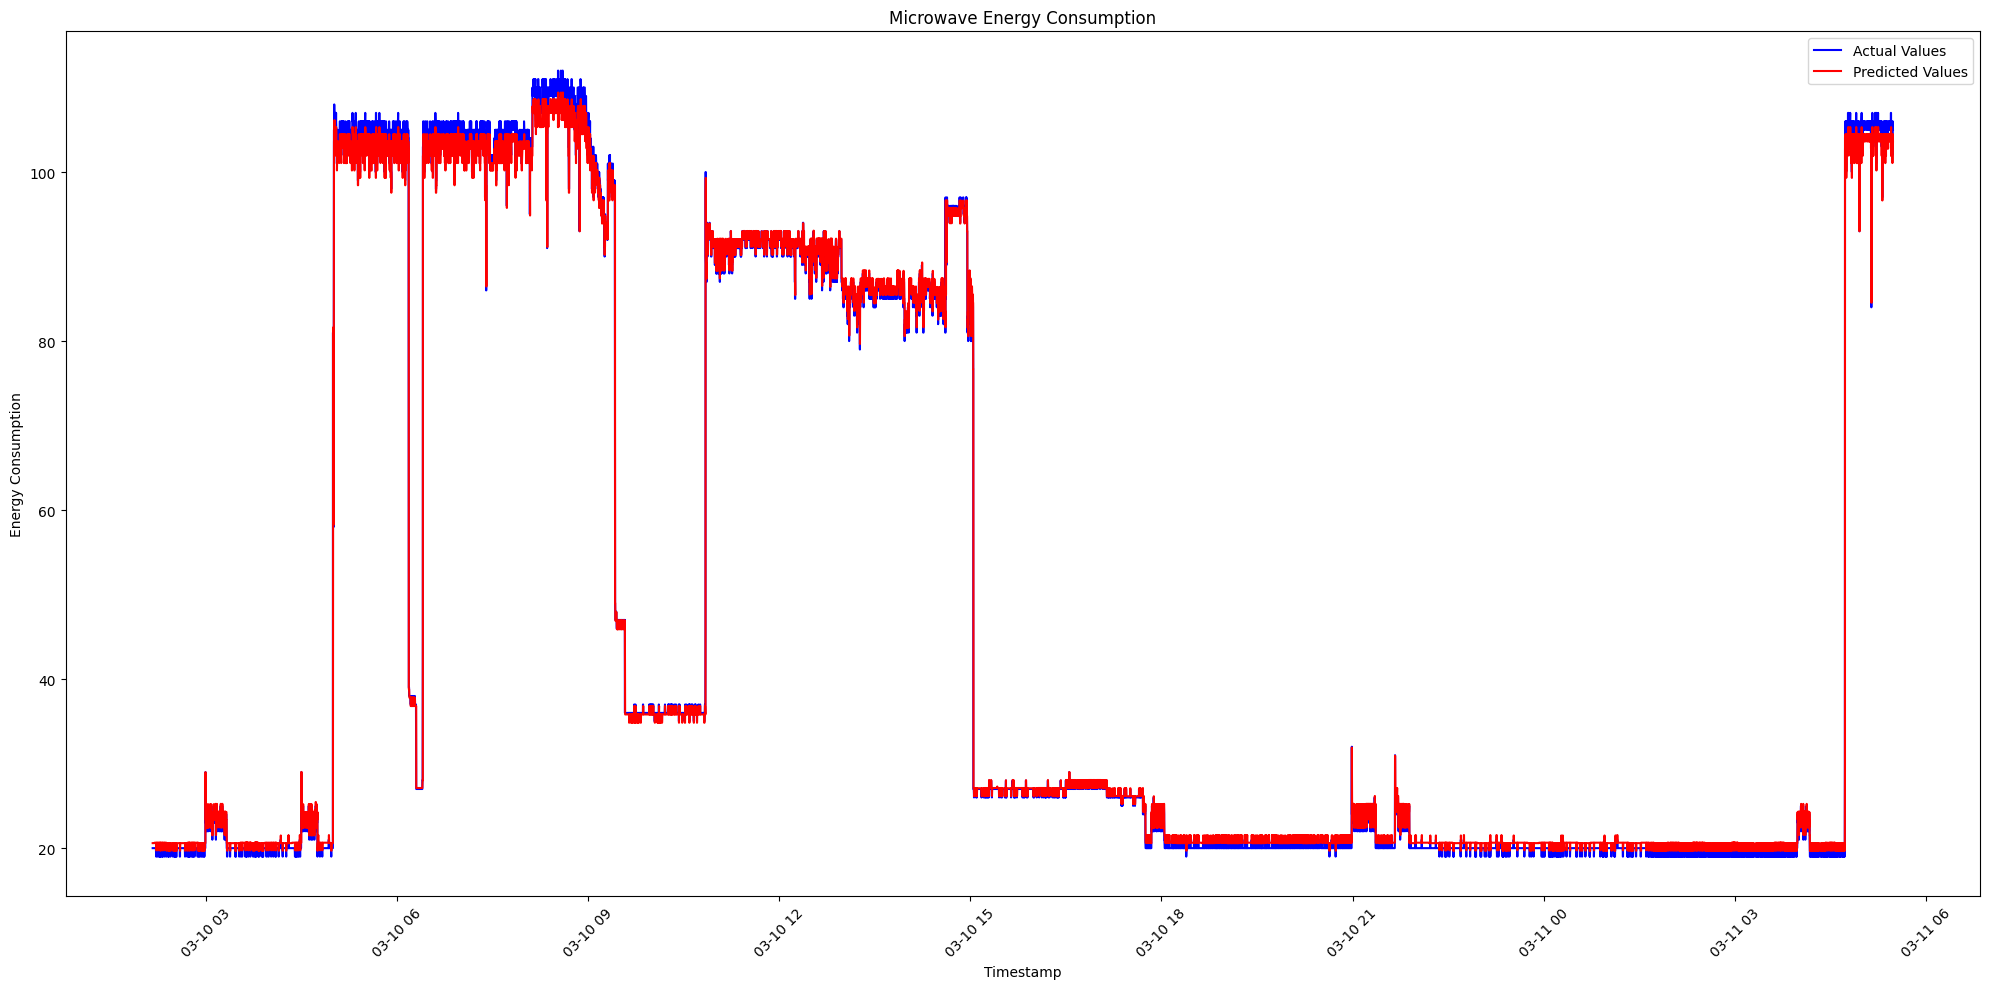

In [ ]:
import matplotlib.pyplot as plt

# Plot actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(tv_output['Timestamp'], tv_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(tv_output['Timestamp'], tv_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
min_length = min(len(timestamp_index), len(house_2_y), len(house_2_predictions))


timestamp_index = timestamp_index[:min_length]
house_2_y = house_2_y[:min_length]
house_2_predictions = house_2_predictions[:min_length]


microwave_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': house_2_y[:, 2],
    'Predicted Values': house_2_predictions[:, 2]
})


print("Microwave:")
print(microwave_output.head(20))


Microwave:
             Timestamp  Actual Values  Predicted Values
0  2014-03-10 02:09:45            1.0          2.684291
1  2014-03-10 02:09:48            1.0          2.674863
2  2014-03-10 02:09:59            1.0          2.684291
3  2014-03-10 02:10:02            1.0          2.693611
4  2014-03-10 02:10:14            1.0          2.693611
5  2014-03-10 02:10:16            1.0          2.693611
6  2014-03-10 02:10:18            1.0          2.684291
7  2014-03-10 02:10:28            1.0          2.684291
8  2014-03-10 02:10:31            1.0          2.684291
9  2014-03-10 02:10:33            1.0          2.684291
10 2014-03-10 02:10:45            1.0          2.684291
11 2014-03-10 02:10:47            1.0          2.693611
12 2014-03-10 02:10:59            1.0          2.693611
13 2014-03-10 02:11:01            1.0          2.693611
14 2014-03-10 02:11:13            1.0          2.693611
15 2014-03-10 02:11:16            1.0          2.693611
16 2014-03-10 02:11:19            1.0

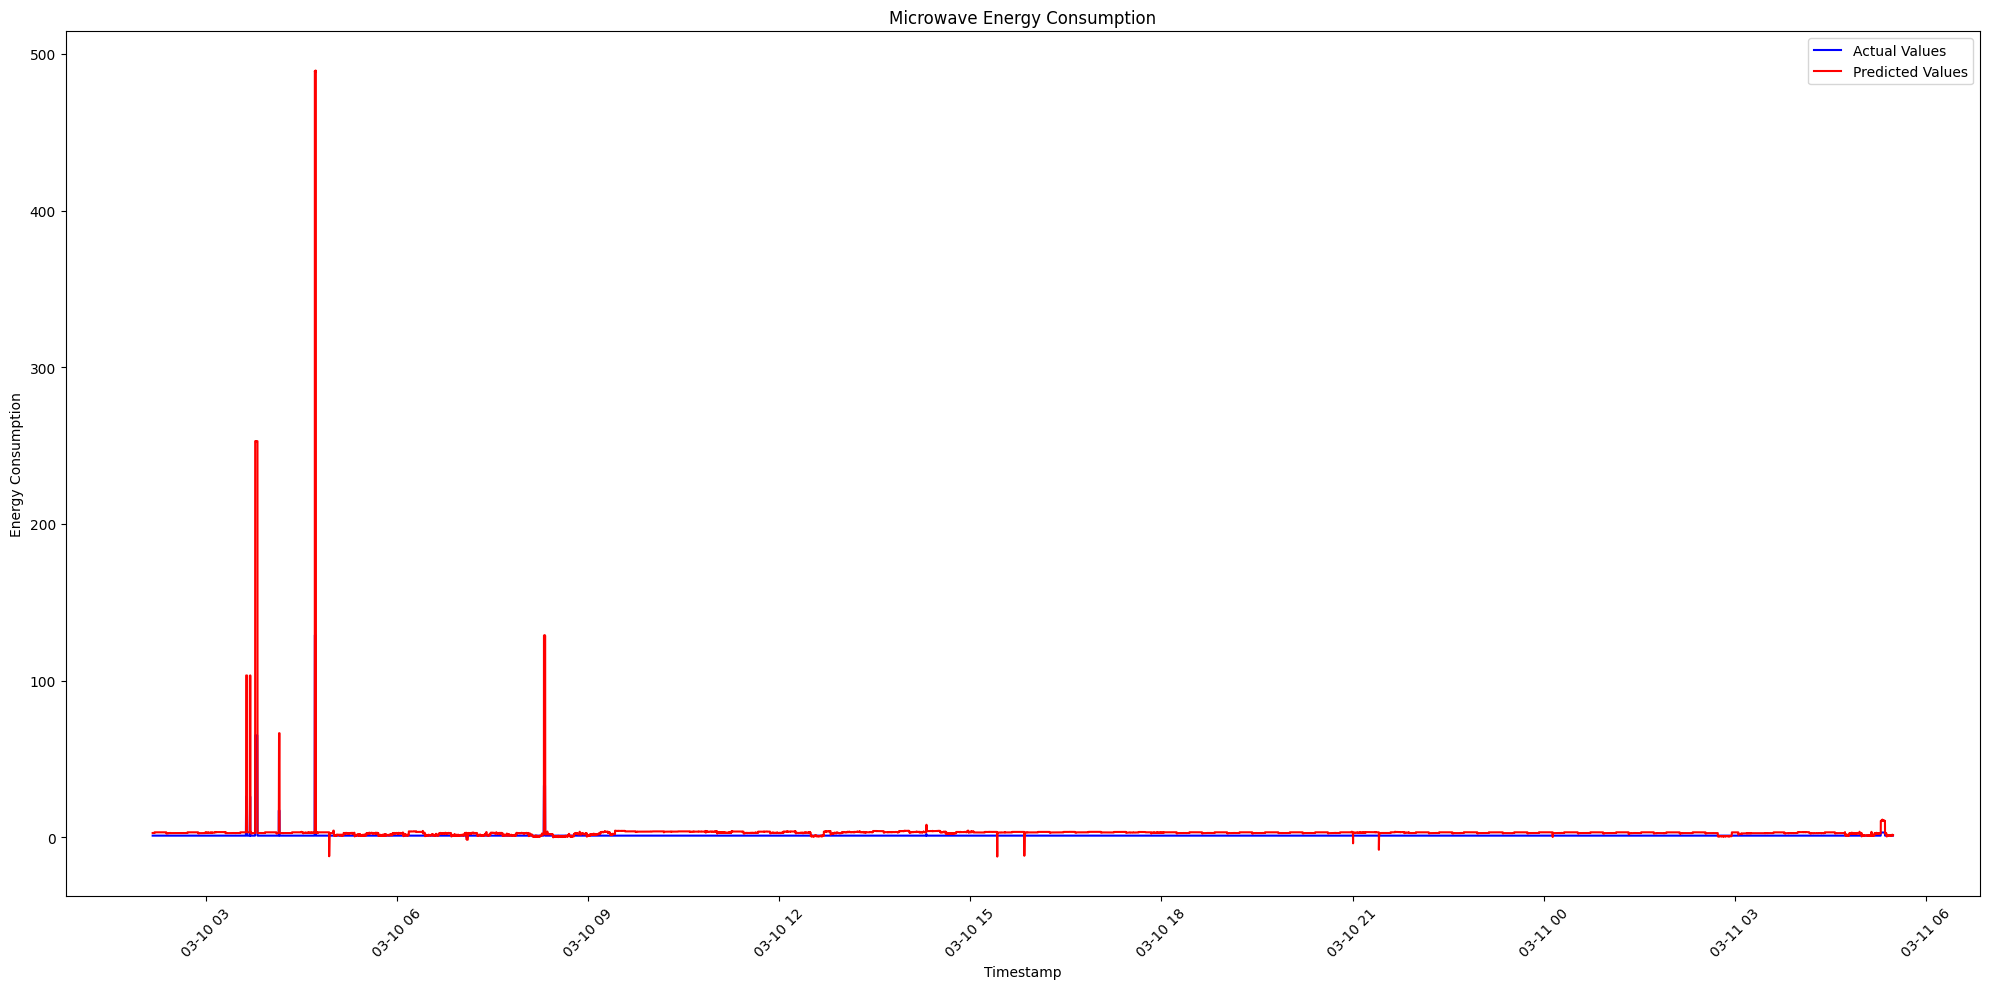

In [ ]:
import matplotlib.pyplot as plt

# Plot actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(microwave_output['Timestamp'], microwave_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(microwave_output['Timestamp'], microwave_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Predicting energy consumption for House 1...
523/523 [==============================] - 1s 3ms/step
Predicting energy consumption for House 2...
505/505 [==============================] - 1s 2ms/step
Predicting energy consumption for House 3...
529/529 [==============================] - 1s 1ms/step


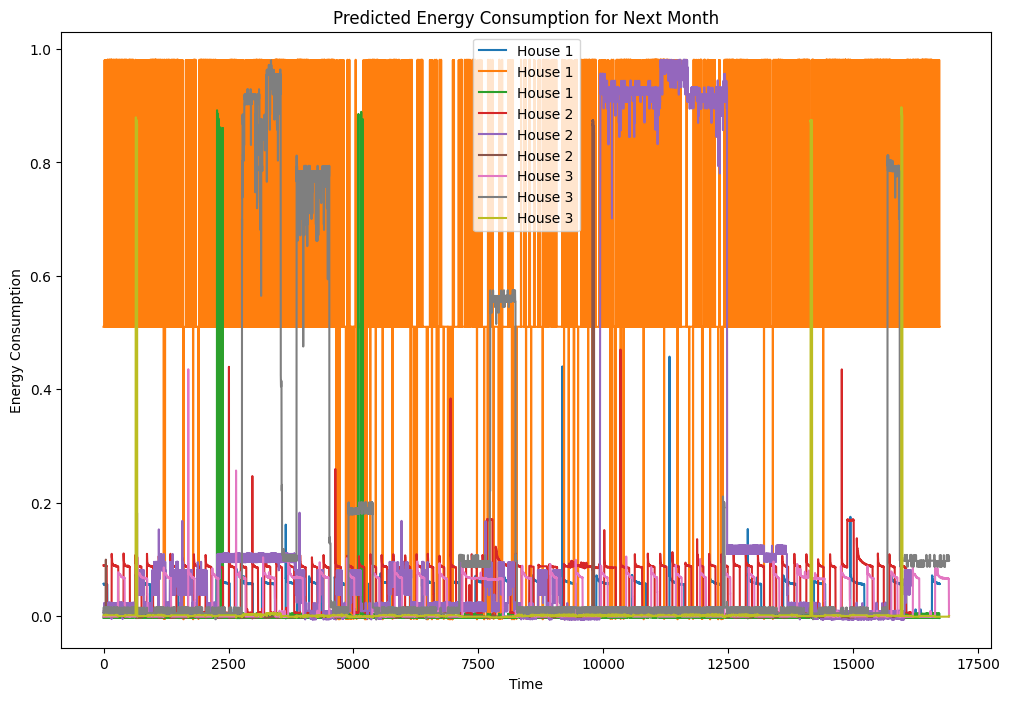

In [ ]:
# Predict the energy consumption for the next month
num_future_steps = 30 * 24  # Assuming hourly data and 30 days
predicted_values = {}
for house in range(1, 4):
    print(f"Predicting energy consumption for House {house}...")
    predicted_values[house] = model.predict(test_X[house])

# Plot the predicted energy consumption for each house
plt.figure(figsize=(12, 8))
for house in range(1, 4):
    plt.plot(predicted_values[house], label=f'House {house}')

plt.title('Predicted Energy Consumption for Next Month')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

## STACKED LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define a function to build a stacked LSTM model
def stacked_lstm(input_shape):

    stacked_model = Sequential()
    stacked_model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=input_shape))
    stacked_model.add(LSTM(units=64, activation='relu'))
    stacked_model.add(Dense(units=3))
    return stacked_model


stacked_model = stacked_lstm(input_shape=(train_X[1].shape[1], train_X[1].shape[2]))


stacked_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 50627 (197.76 KB)
Trainable params: 50627 (197.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the learning rate
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

# Compile the vanilla LSTM model
stacked_model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])




In [ ]:

history_stacked= stacked_model.fit(train_X[1], train_y[1], epochs=100, batch_size=32, validation_data=(test_X[1], test_y[1]))



Epoch 1/100
1220/1220 [==============================] - 9s 4ms/step - loss: 0.0015 - accuracy: 0.9972 - val_loss: 0.0159 - val_accuracy: 0.9913
Epoch 2/100
1220/1220 [==============================] - 5s 4ms/step - loss: 3.3107e-04 - accuracy: 0.9988 - val_loss: 0.0150 - val_accuracy: 0.9912
Epoch 3/100
1220/1220 [==============================] - 5s 4ms/step - loss: 3.2200e-04 - accuracy: 0.9988 - val_loss: 0.0141 - val_accuracy: 0.9913
Epoch 4/100
1220/1220 [==============================] - 5s 4ms/step - loss: 3.2165e-04 - accuracy: 0.9988 - val_loss: 0.0135 - val_accuracy: 0.9912
Epoch 5/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.2352e-04 - accuracy: 0.9988 - val_loss: 0.0134 - val_accuracy: 0.9913
Epoch 6/100
1220/1220 [==============================] - 5s 4ms/step - loss: 3.2291e-04 - accuracy: 0.9988 - val_loss: 0.0131 - val_accuracy: 0.9913
Epoch 7/100
1220/1220 [==============================] - 5s 4ms/step - loss: 3.1565e-04 - accuracy: 0.9988 - v

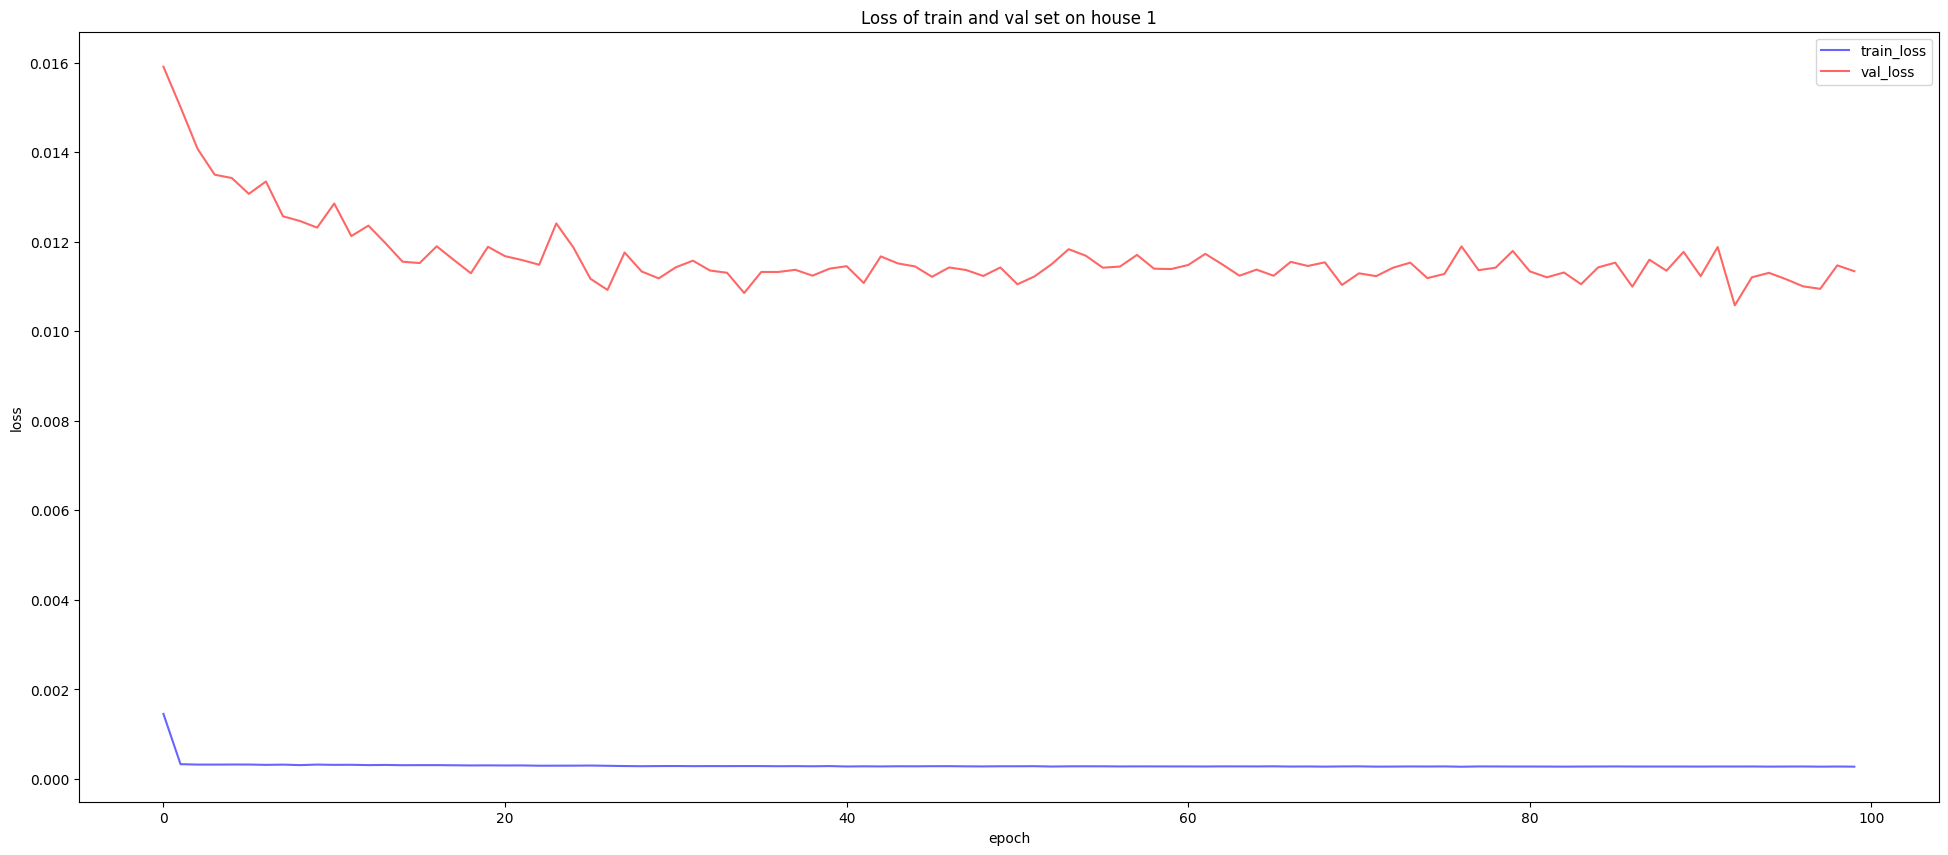

In [ ]:
train_loss = history_stacked.history['loss']
val_loss = history_stacked.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Loss of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

In [ ]:
# Evaluataccuracye the model on test data
loss, accuracy = stacked_model.evaluate(train_X[1], train_y[1])
print("Train Loss:", loss)
print("Train Accuracy: ", accuracy)

1220/1220 [==============================] - 3s 2ms/step - loss: 2.6776e-04 - accuracy: 0.9989
Train Loss: 0.0002677601296454668
Train Accuracy:  0.9989240169525146


In [ ]:
# Evaluate the model on test data
loss, accuracy = stacked_model.evaluate(test_X[1], test_y[1])
print("Test Loss:", loss)
print("Test Accuracy: ", accuracy)

523/523 [==============================] - 1s 2ms/step - loss: 0.0113 - accuracy: 0.9913
Test Loss: 0.011339866556227207
Test Accuracy:  0.9912720918655396


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Predict energy consumption using the trained stacked LSTM model
predictions = stacked_model.predict(test_X[1])

import numpy as np


# Inverse transform predictions using the scaler
predictions = test_scalers[1].inverse_transform(predictions)


# Inverse transform the actual values to get the original scale of energy consumption
actual_values = test_scalers[1].inverse_transform(test_y[1])




mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y[1], predictions)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

523/523 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 1612.9092571746314
Root Mean Squared Error (RMSE): 40.16104153498302
Mean Absolute Error (MAE): 33.99031508646642


In [ ]:
# Fridge


timestamp_index = test_data[1].index[:len(predictions)]

fridge_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 0],
    'Predicted Values': predictions[:, 0]
})

print("Fridge:")
print(fridge_output.head(20))


Fridge:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13           73.0         69.971039
1  2014-03-09 10:13:15           73.0         68.809975
2  2014-03-09 10:13:20           73.0         68.809975
3  2014-03-09 10:13:27           73.0         68.809975
4  2014-03-09 10:13:29           74.0         68.809975
5  2014-03-09 10:13:34           73.0         69.971039
6  2014-03-09 10:13:43           74.0         68.809975
7  2014-03-09 10:13:48           72.0         69.971039
8  2014-03-09 10:13:57           72.0         67.647263
9  2014-03-09 10:14:02           74.0         67.647263
10 2014-03-09 10:14:12           73.0         69.971039
11 2014-03-09 10:14:16           73.0         68.809975
12 2014-03-09 10:14:19           73.0         68.809975
13 2014-03-09 10:14:26           74.0         68.809975
14 2014-03-09 10:14:31           74.0         69.971039
15 2014-03-09 10:14:33           74.0         69.971039
16 2014-03-09 10:14:45           73.0   

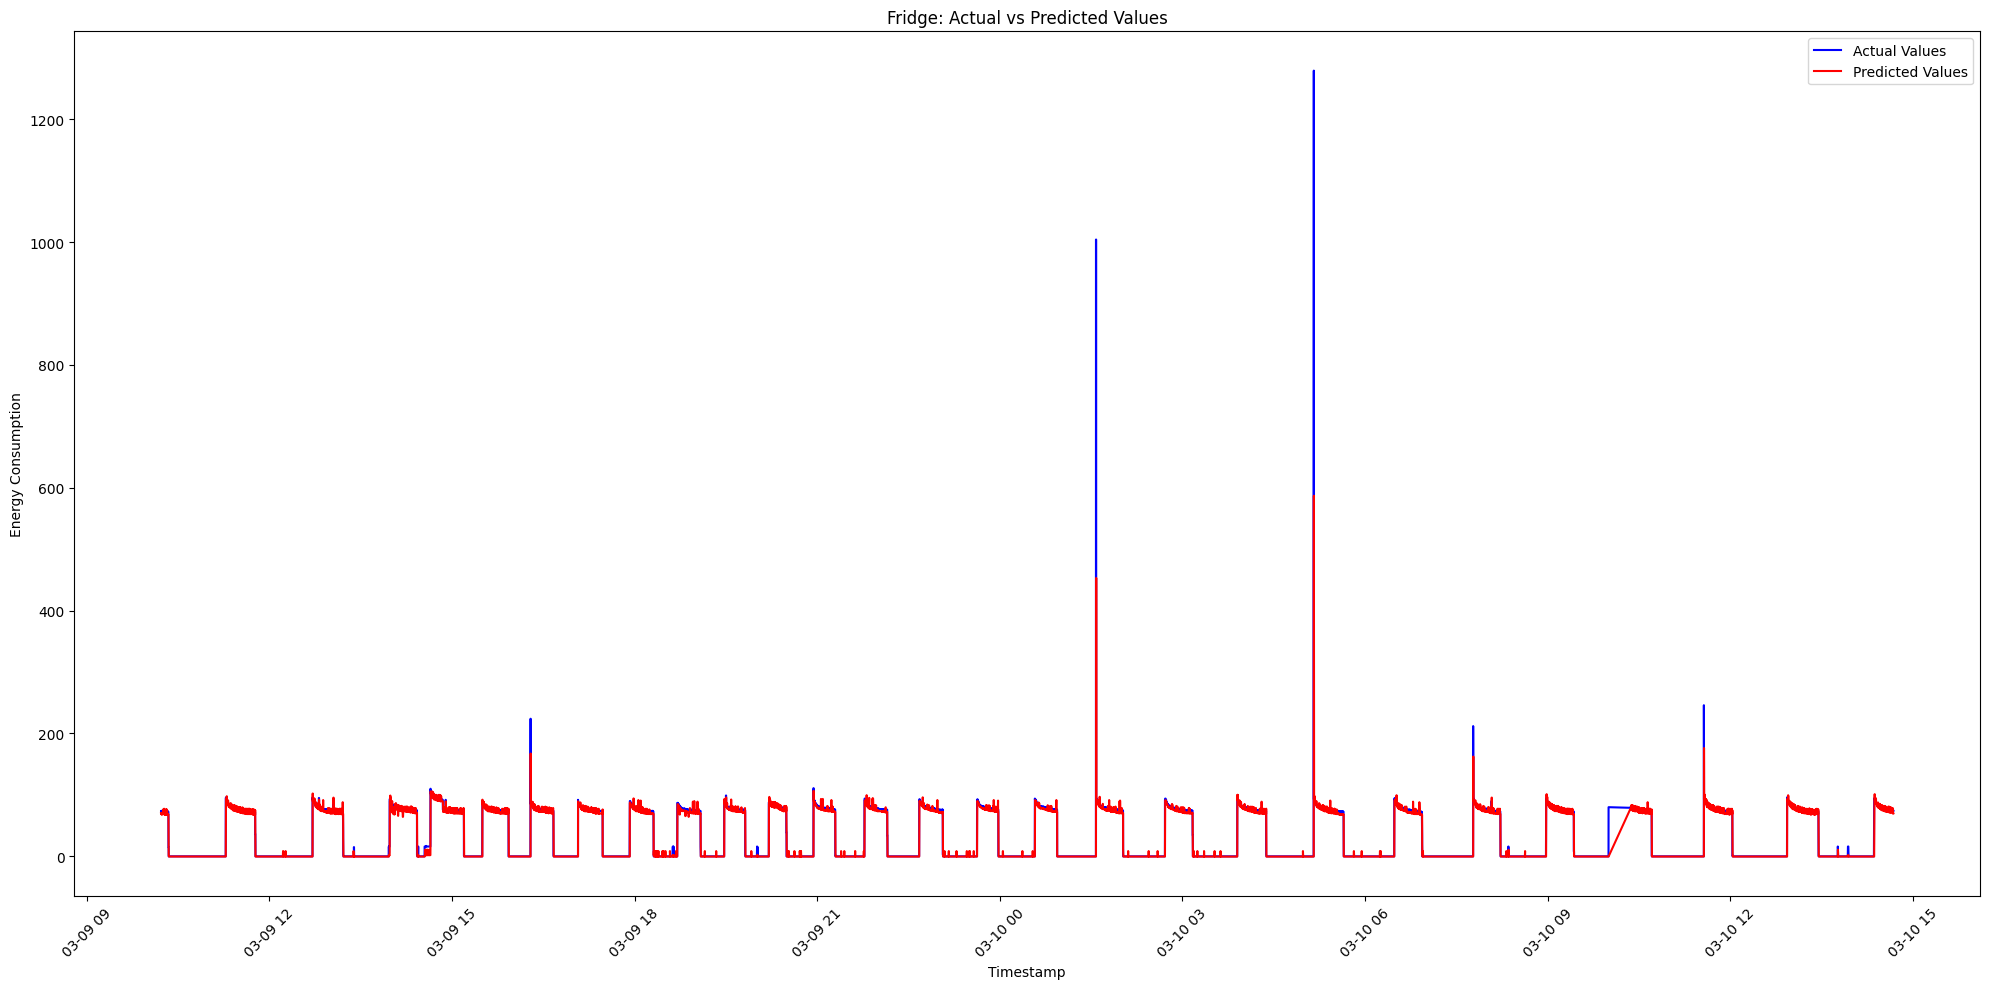

In [ ]:
# Plot actual and predicted values

plt.figure(figsize=(20, 10))
plt.plot(fridge_output['Timestamp'], fridge_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(fridge_output['Timestamp'], fridge_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Fridge: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Television

timestamp_index = test_data[1].index[:len(predictions)]


tv_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 1],
    'Predicted Values': predictions[:, 1]
})

print("Television:")
print(tv_output.head(20))


Television:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13           21.0         21.121775
1  2014-03-09 10:13:15           21.0         21.121801
2  2014-03-09 10:13:20           21.0         21.121801
3  2014-03-09 10:13:27           21.0         21.121801
4  2014-03-09 10:13:29           21.0         21.121801
5  2014-03-09 10:13:34           21.0         21.121775
6  2014-03-09 10:13:43           21.0         21.121801
7  2014-03-09 10:13:48           21.0         21.121775
8  2014-03-09 10:13:57           21.0         21.121826
9  2014-03-09 10:14:02           21.0         21.121826
10 2014-03-09 10:14:12           21.0         21.121775
11 2014-03-09 10:14:16           21.0         21.121801
12 2014-03-09 10:14:19           21.0         21.121801
13 2014-03-09 10:14:26           21.0         21.121801
14 2014-03-09 10:14:31           21.0         21.121775
15 2014-03-09 10:14:33           21.0         21.121775
16 2014-03-09 10:14:45           21.

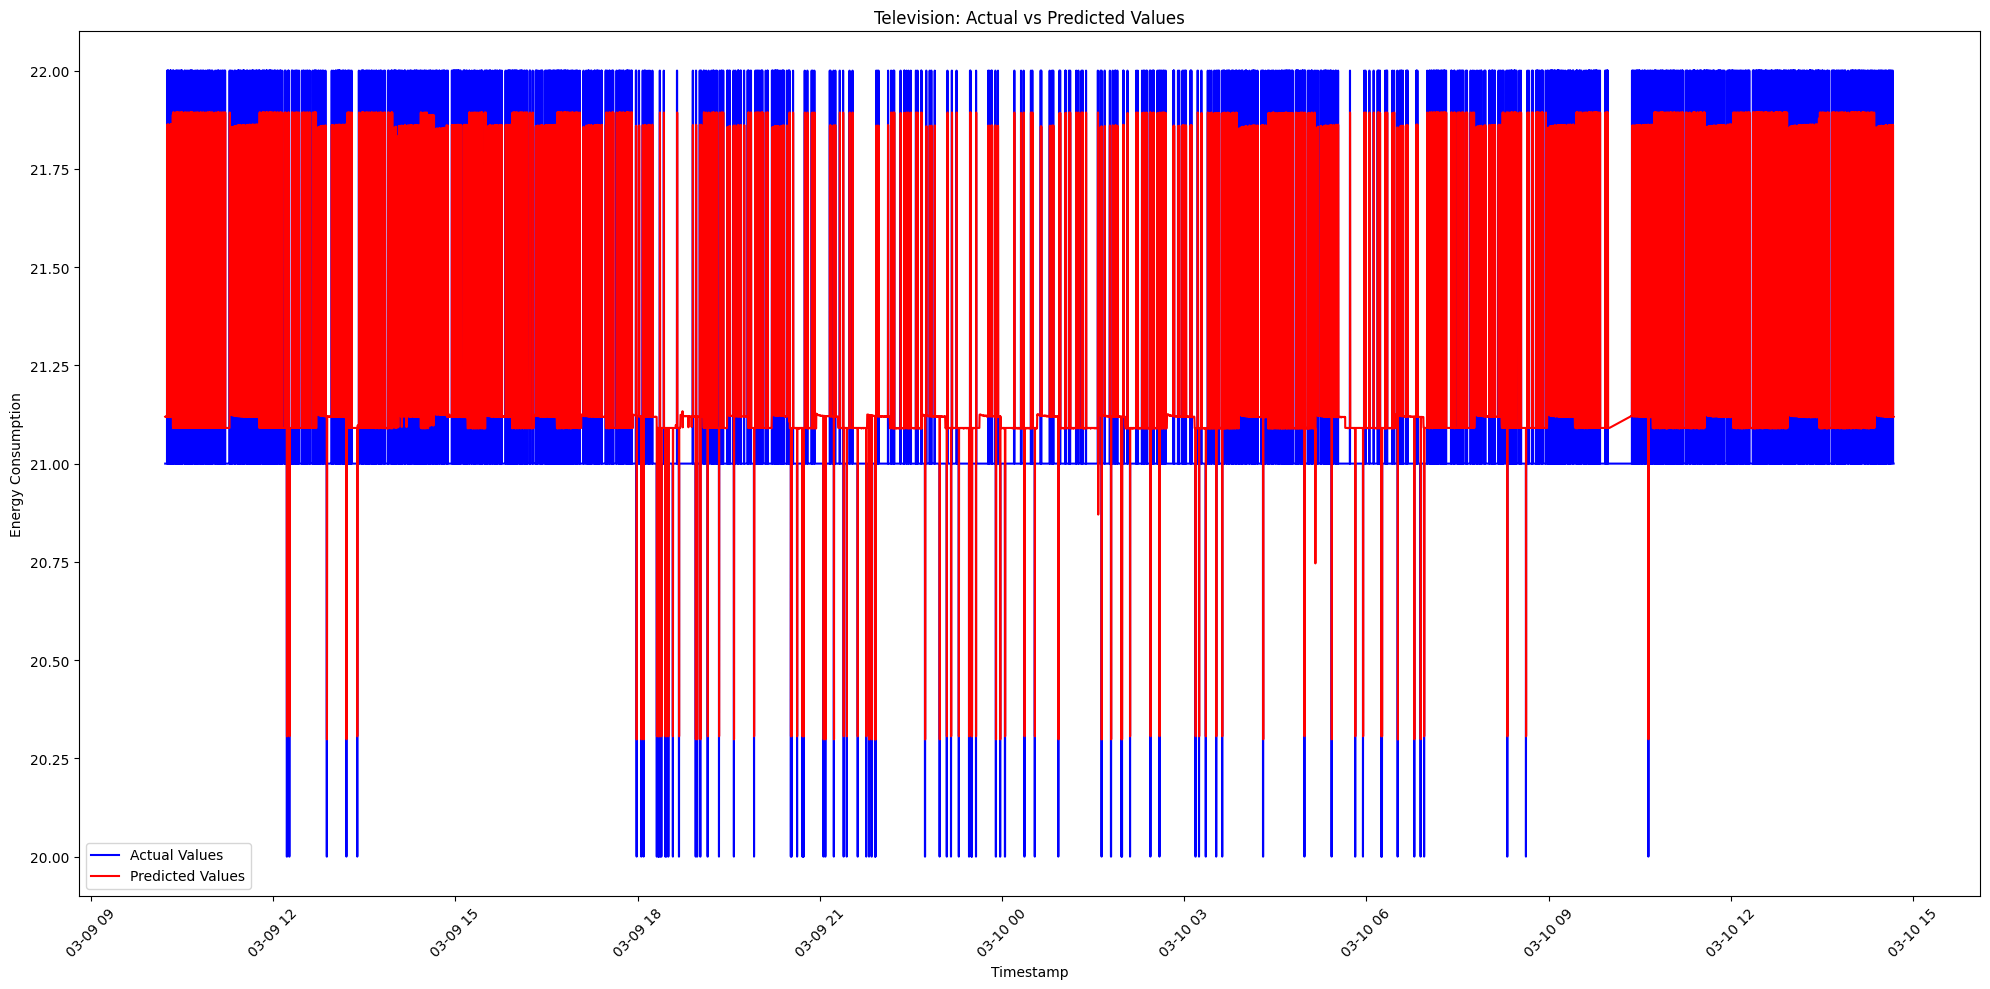

In [ ]:
# Plot actual and predicted values


plt.figure(figsize=(20, 10))
plt.plot(tv_output['Timestamp'], tv_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(tv_output['Timestamp'], tv_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Television: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#Microwave

timestamp_index = test_data[1].index[:len(predictions)]


microwave_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 2],
    'Predicted Values': predictions[:, 2]
})


print("Microwave:")
print(microwave_output.head(20))




Microwave:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13            2.0          5.628614
1  2014-03-09 10:13:15            2.0          5.636516
2  2014-03-09 10:13:20            2.0          5.636516
3  2014-03-09 10:13:27            2.0          5.636516
4  2014-03-09 10:13:29            2.0          5.636516
5  2014-03-09 10:13:34            2.0          5.628614
6  2014-03-09 10:13:43            2.0          5.636516
7  2014-03-09 10:13:48            2.0          5.628614
8  2014-03-09 10:13:57            2.0          5.644355
9  2014-03-09 10:14:02            2.0          5.644355
10 2014-03-09 10:14:12            2.0          5.628614
11 2014-03-09 10:14:16            2.0          5.636516
12 2014-03-09 10:14:19            2.0          5.636516
13 2014-03-09 10:14:26            2.0          5.636516
14 2014-03-09 10:14:31            2.0          5.628614
15 2014-03-09 10:14:33            2.0          5.628614
16 2014-03-09 10:14:45            2.0

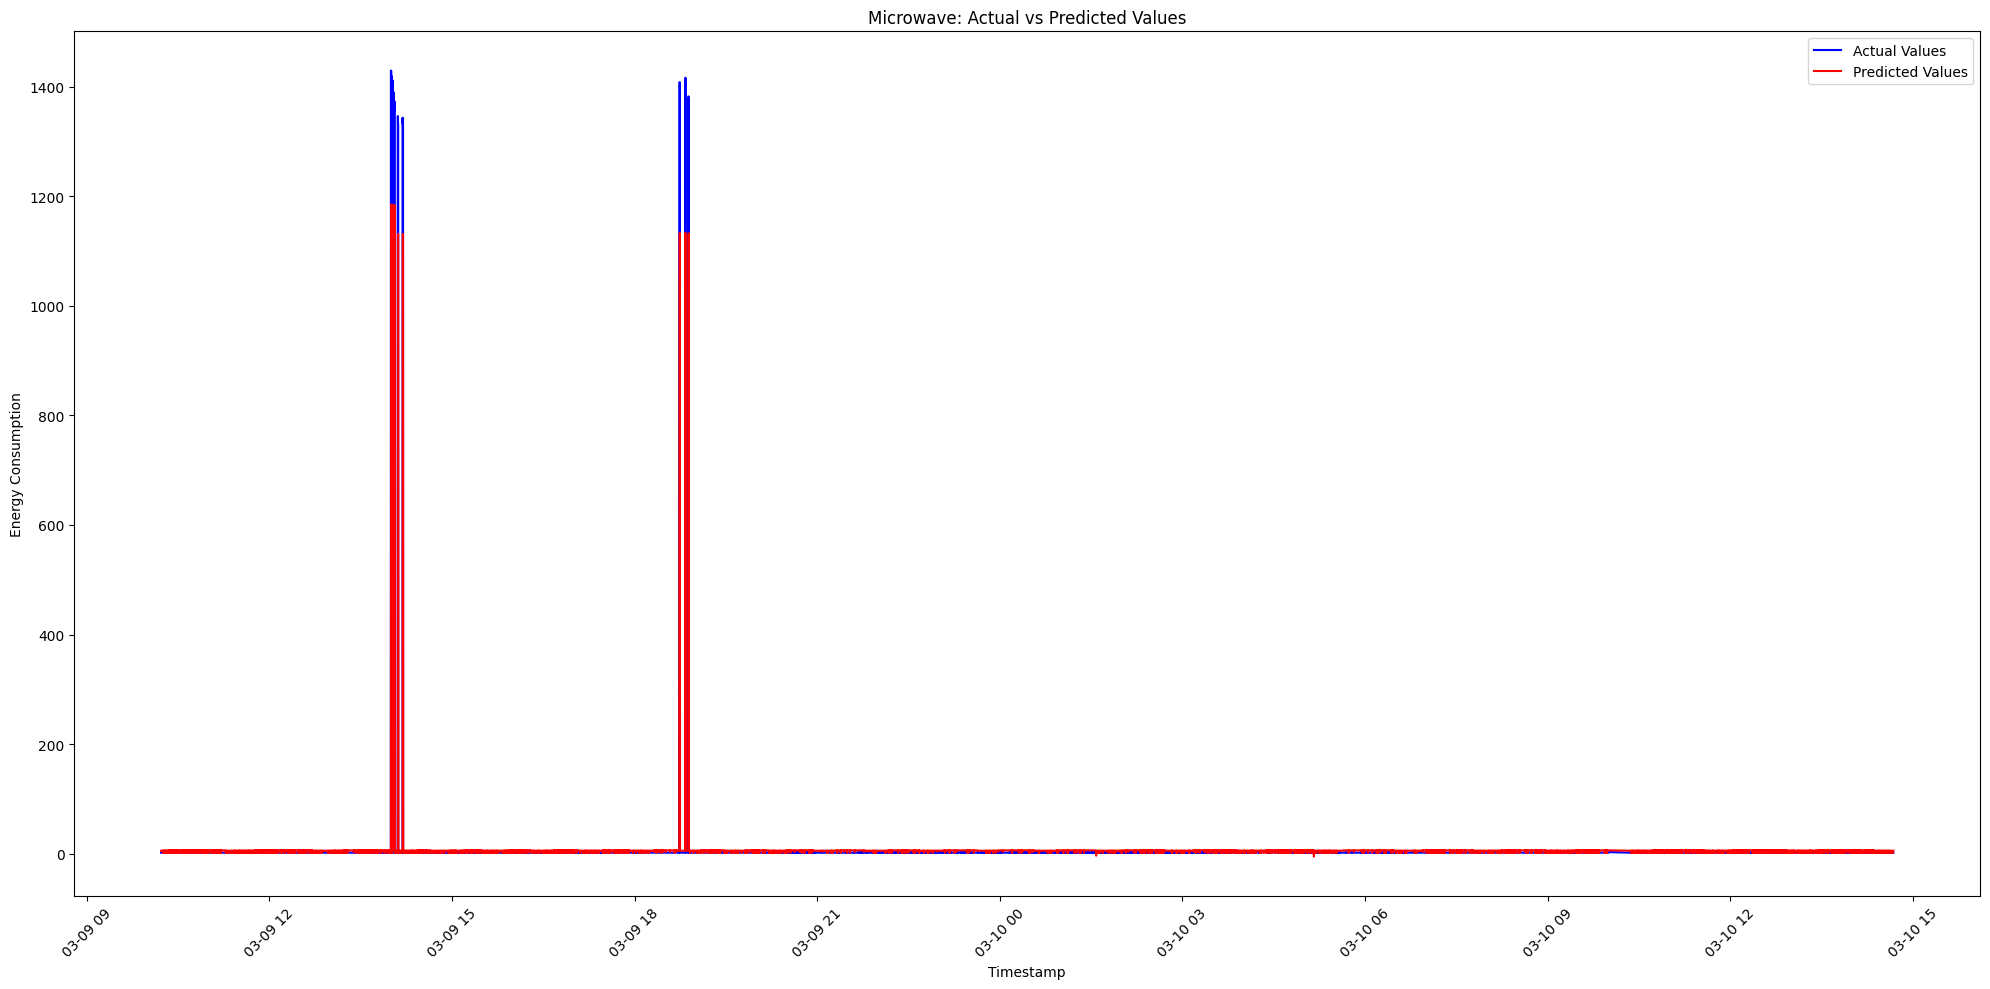

In [ ]:
# Plot actual and predicted values

plt.figure(figsize=(20, 10))
plt.plot(microwave_output['Timestamp'], microwave_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(microwave_output['Timestamp'], microwave_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## BIDIRECTIONAL LSTM

In [ ]:
# Bidirectional LSTM model architecture

def build_bidirectional_lstm_model(input_shape):
    bidirectional_model = Sequential([
        Bidirectional(LSTM(units=64), input_shape=input_shape),
        Dense(units=3)
    ])
    return bidirectional_model


bidirectional_model = build_bidirectional_lstm_model(input_shape=(train_X[1].shape[1], train_X[1].shape[2]))

bidirectional_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               34816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 35203 (137.51 KB)
Trainable params: 35203 (137.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the learning rate
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

# Compile the bidirectional LSTM mode
bidirectional_model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])




In [ ]:
# Train the bidirectional LSTM model
history_bi = bidirectional_model.fit(train_X[1], train_y[1], epochs=100, batch_size=32, validation_data=(test_X[1], test_y[1]))


Epoch 1/100
1220/1220 [==============================] - 6s 5ms/step - loss: 3.1374e-04 - accuracy: 0.9988 - val_loss: 0.0131 - val_accuracy: 0.9898
Epoch 2/100
1220/1220 [==============================] - 6s 5ms/step - loss: 3.0958e-04 - accuracy: 0.9987 - val_loss: 0.0130 - val_accuracy: 0.9898
Epoch 3/100
1220/1220 [==============================] - 5s 4ms/step - loss: 3.1334e-04 - accuracy: 0.9988 - val_loss: 0.0131 - val_accuracy: 0.9872
Epoch 4/100
1220/1220 [==============================] - 7s 6ms/step - loss: 3.1056e-04 - accuracy: 0.9987 - val_loss: 0.0132 - val_accuracy: 0.9903
Epoch 5/100
1220/1220 [==============================] - 7s 6ms/step - loss: 3.1314e-04 - accuracy: 0.9988 - val_loss: 0.0133 - val_accuracy: 0.9872
Epoch 6/100
1220/1220 [==============================] - 7s 6ms/step - loss: 3.1244e-04 - accuracy: 0.9988 - val_loss: 0.0132 - val_accuracy: 0.9885
Epoch 7/100
1220/1220 [==============================] - 6s 5ms/step - loss: 3.1053e-04 - accuracy: 0.9987

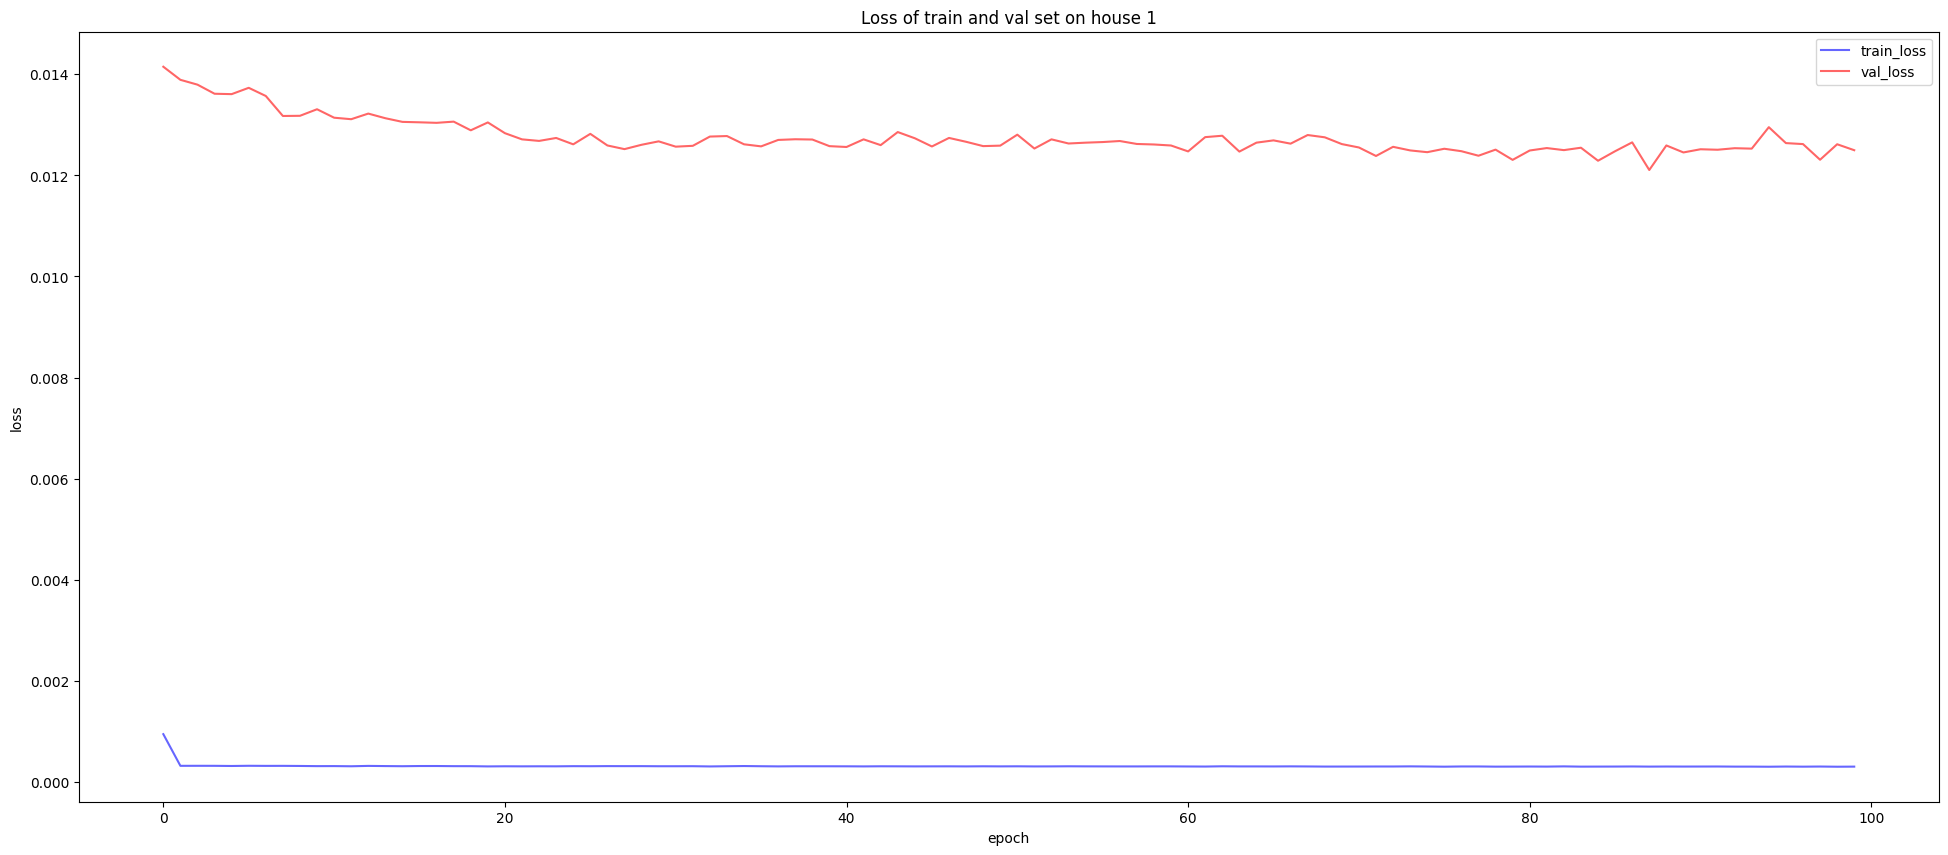

In [ ]:
train_loss = history_bi.history['loss']
val_loss = history_bi.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Loss of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

In [ ]:
# Evaluataccuracye the model on Train data
loss, accuracy = bidirectional_model.evaluate(train_X[1], train_y[1])
print("Train Loss:", loss)
print("Train Accuracy: ", accuracy)

1220/1220 [==============================] - 3s 2ms/step - loss: 3.0229e-04 - accuracy: 0.9988
Train Loss: 0.0003022892924491316
Train Accuracy:  0.9987958669662476


In [ ]:
# Evaluate the model on test data
loss, accuracy = stacked_model.evaluate(test_X[1], test_y[1])
print("Test Loss:", loss)
print("Test Accuracy: ", accuracy)

523/523 [==============================] - 1s 3ms/step - loss: 0.0113 - accuracy: 0.9913
Test Loss: 0.011339866556227207
Test Accuracy:  0.9912720918655396


In [ ]:
# Predict energy consumption using the trained LSTM model
predictions = bidirectional_model.predict(test_X[1])


# Inverse transform predictions using the scaler
predictions = test_scalers[1].inverse_transform(predictions)


# Inverse transform the actual values to get the original scale of energy consumption
actual_values = test_scalers[1].inverse_transform(test_y[1])


mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y[1], predictions)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

523/523 [==============================] - 2s 2ms/step
Mean Squared Error (MSE): 698.7939968458771
Root Mean Squared Error (RMSE): 26.43471196827908
Mean Absolute Error (MAE): 22.48530845731052


In [ ]:
import matplotlib.pyplot as plt

# Fridge


timestamp_index = test_data[1].index[:len(predictions)]

fridge_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 0],
    'Predicted Values': predictions[:, 0]
})


print("Fridge:")
print(fridge_output.head(20))


Fridge:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13           73.0         75.437988
1  2014-03-09 10:13:15           73.0         74.548180
2  2014-03-09 10:13:20           73.0         74.548180
3  2014-03-09 10:13:27           73.0         74.548180
4  2014-03-09 10:13:29           74.0         74.548180
5  2014-03-09 10:13:34           73.0         75.437988
6  2014-03-09 10:13:43           74.0         74.548180
7  2014-03-09 10:13:48           72.0         75.437988
8  2014-03-09 10:13:57           72.0         73.657402
9  2014-03-09 10:14:02           74.0         73.657402
10 2014-03-09 10:14:12           73.0         75.437988
11 2014-03-09 10:14:16           73.0         74.548180
12 2014-03-09 10:14:19           73.0         74.548180
13 2014-03-09 10:14:26           74.0         74.548180
14 2014-03-09 10:14:31           74.0         75.437988
15 2014-03-09 10:14:33           74.0         75.437988
16 2014-03-09 10:14:45           73.0   

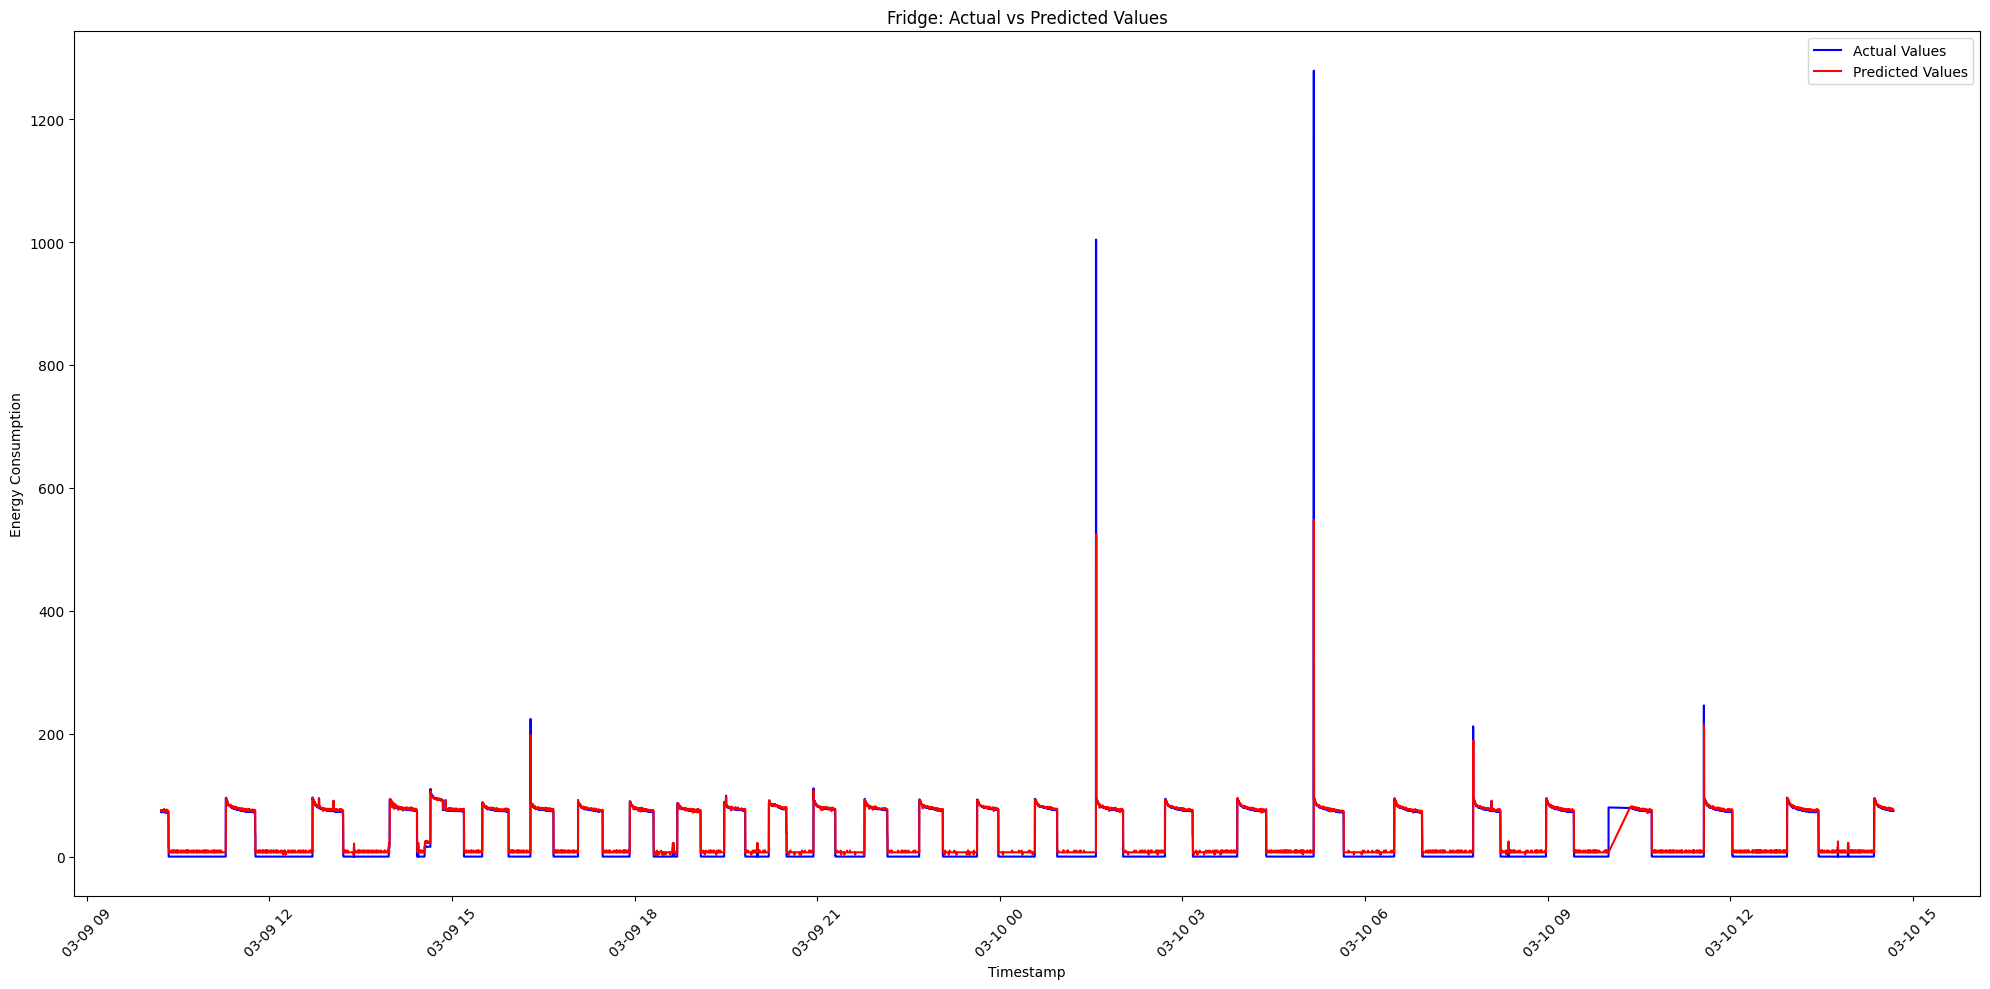

In [ ]:
# Plot actual and predicted values

plt.figure(figsize=(20, 10))
plt.plot(fridge_output['Timestamp'], fridge_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(fridge_output['Timestamp'], fridge_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Fridge: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Television

timestamp_index = test_data[1].index[:len(predictions)]


tv_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 1],
    'Predicted Values': predictions[:, 1]
})

print("Television:")
print(tv_output.head(20))

Television:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13           21.0         21.010021
1  2014-03-09 10:13:15           21.0         21.010014
2  2014-03-09 10:13:20           21.0         21.010014
3  2014-03-09 10:13:27           21.0         21.010014
4  2014-03-09 10:13:29           21.0         21.010014
5  2014-03-09 10:13:34           21.0         21.010021
6  2014-03-09 10:13:43           21.0         21.010014
7  2014-03-09 10:13:48           21.0         21.010021
8  2014-03-09 10:13:57           21.0         21.010006
9  2014-03-09 10:14:02           21.0         21.010006
10 2014-03-09 10:14:12           21.0         21.010021
11 2014-03-09 10:14:16           21.0         21.010014
12 2014-03-09 10:14:19           21.0         21.010014
13 2014-03-09 10:14:26           21.0         21.010014
14 2014-03-09 10:14:31           21.0         21.010021
15 2014-03-09 10:14:33           21.0         21.010021
16 2014-03-09 10:14:45           21.

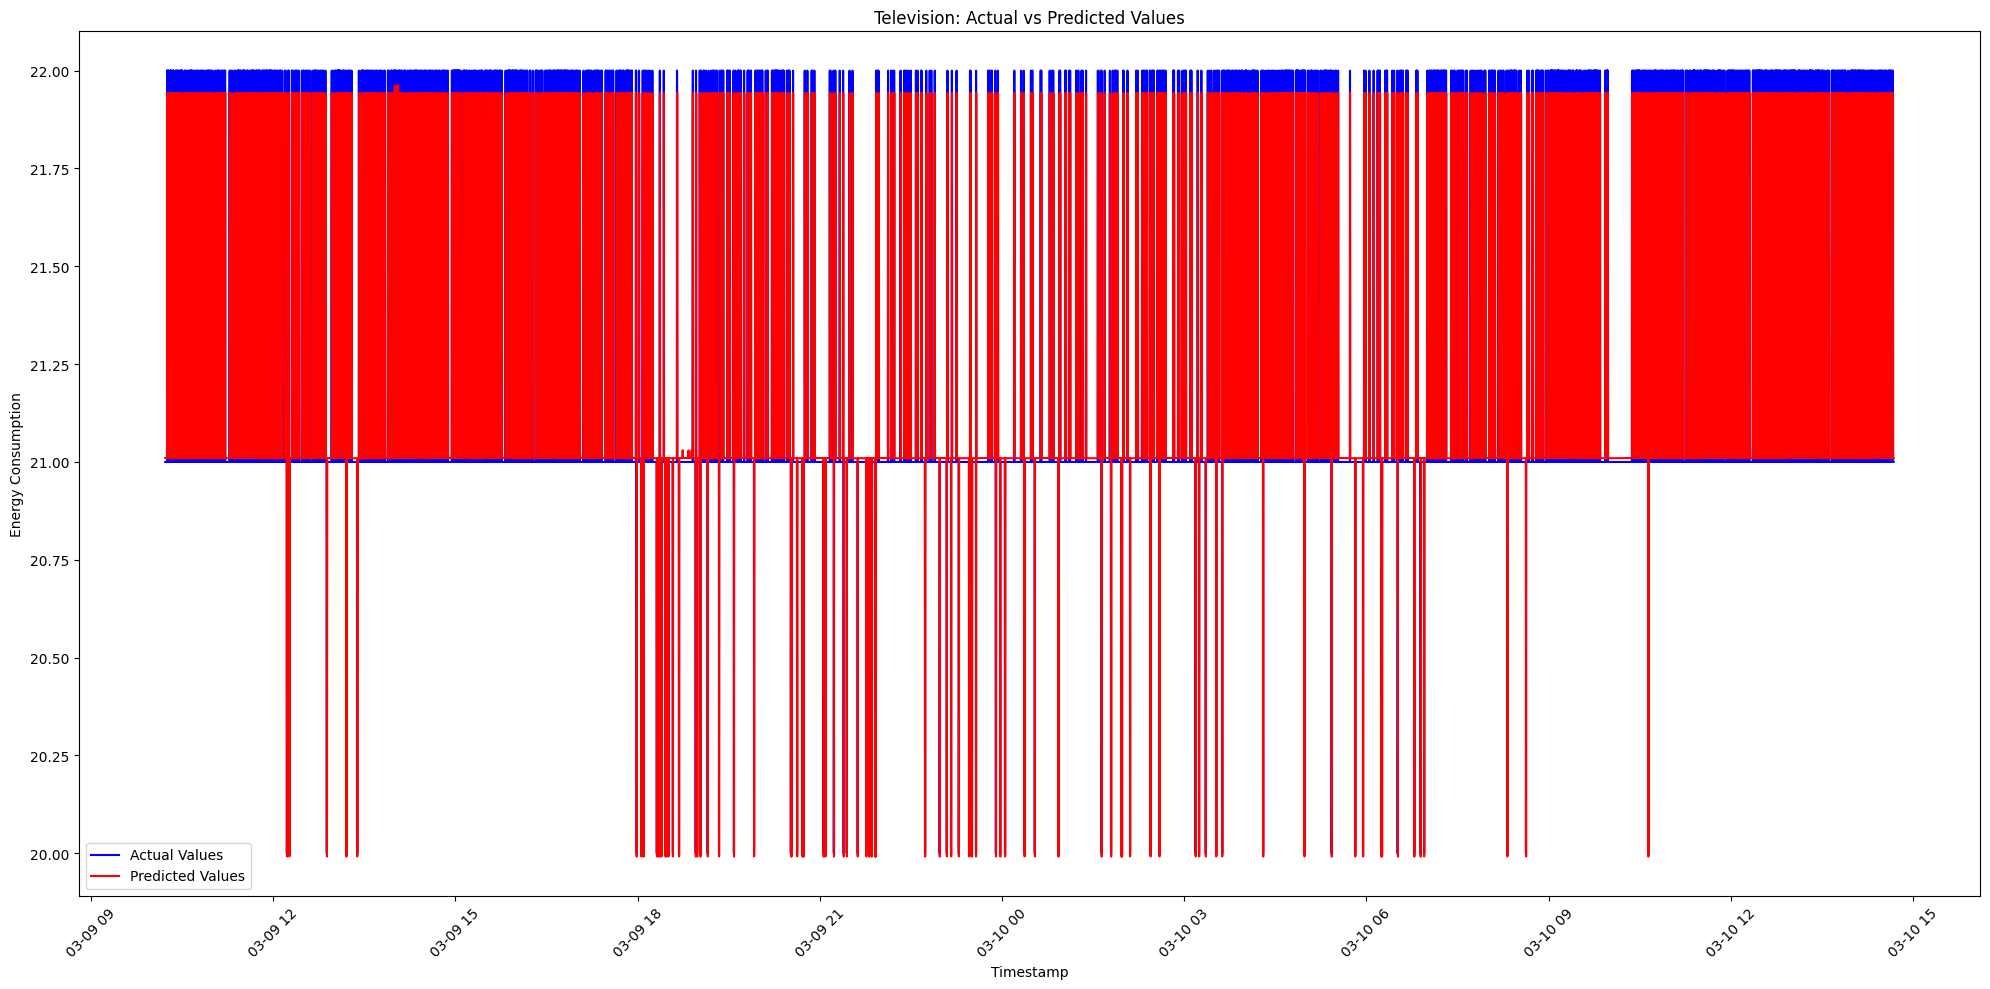

In [ ]:
# Plot actual and predicted values


plt.figure(figsize=(20, 10))
plt.plot(tv_output['Timestamp'], tv_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(tv_output['Timestamp'], tv_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Television: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Microwave
timestamp_index = test_data[1].index[:len(predictions)]


microwave_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 2],
    'Predicted Values': predictions[:, 2]
})

print("Microwave:")
print(microwave_output.head(20))


Microwave:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13            2.0          4.827633
1  2014-03-09 10:13:15            2.0          4.833965
2  2014-03-09 10:13:20            2.0          4.833965
3  2014-03-09 10:13:27            2.0          4.833965
4  2014-03-09 10:13:29            2.0          4.833965
5  2014-03-09 10:13:34            2.0          4.827633
6  2014-03-09 10:13:43            2.0          4.833965
7  2014-03-09 10:13:48            2.0          4.827633
8  2014-03-09 10:13:57            2.0          4.840259
9  2014-03-09 10:14:02            2.0          4.840259
10 2014-03-09 10:14:12            2.0          4.827633
11 2014-03-09 10:14:16            2.0          4.833965
12 2014-03-09 10:14:19            2.0          4.833965
13 2014-03-09 10:14:26            2.0          4.833965
14 2014-03-09 10:14:31            2.0          4.827633
15 2014-03-09 10:14:33            2.0          4.827633
16 2014-03-09 10:14:45            2.0

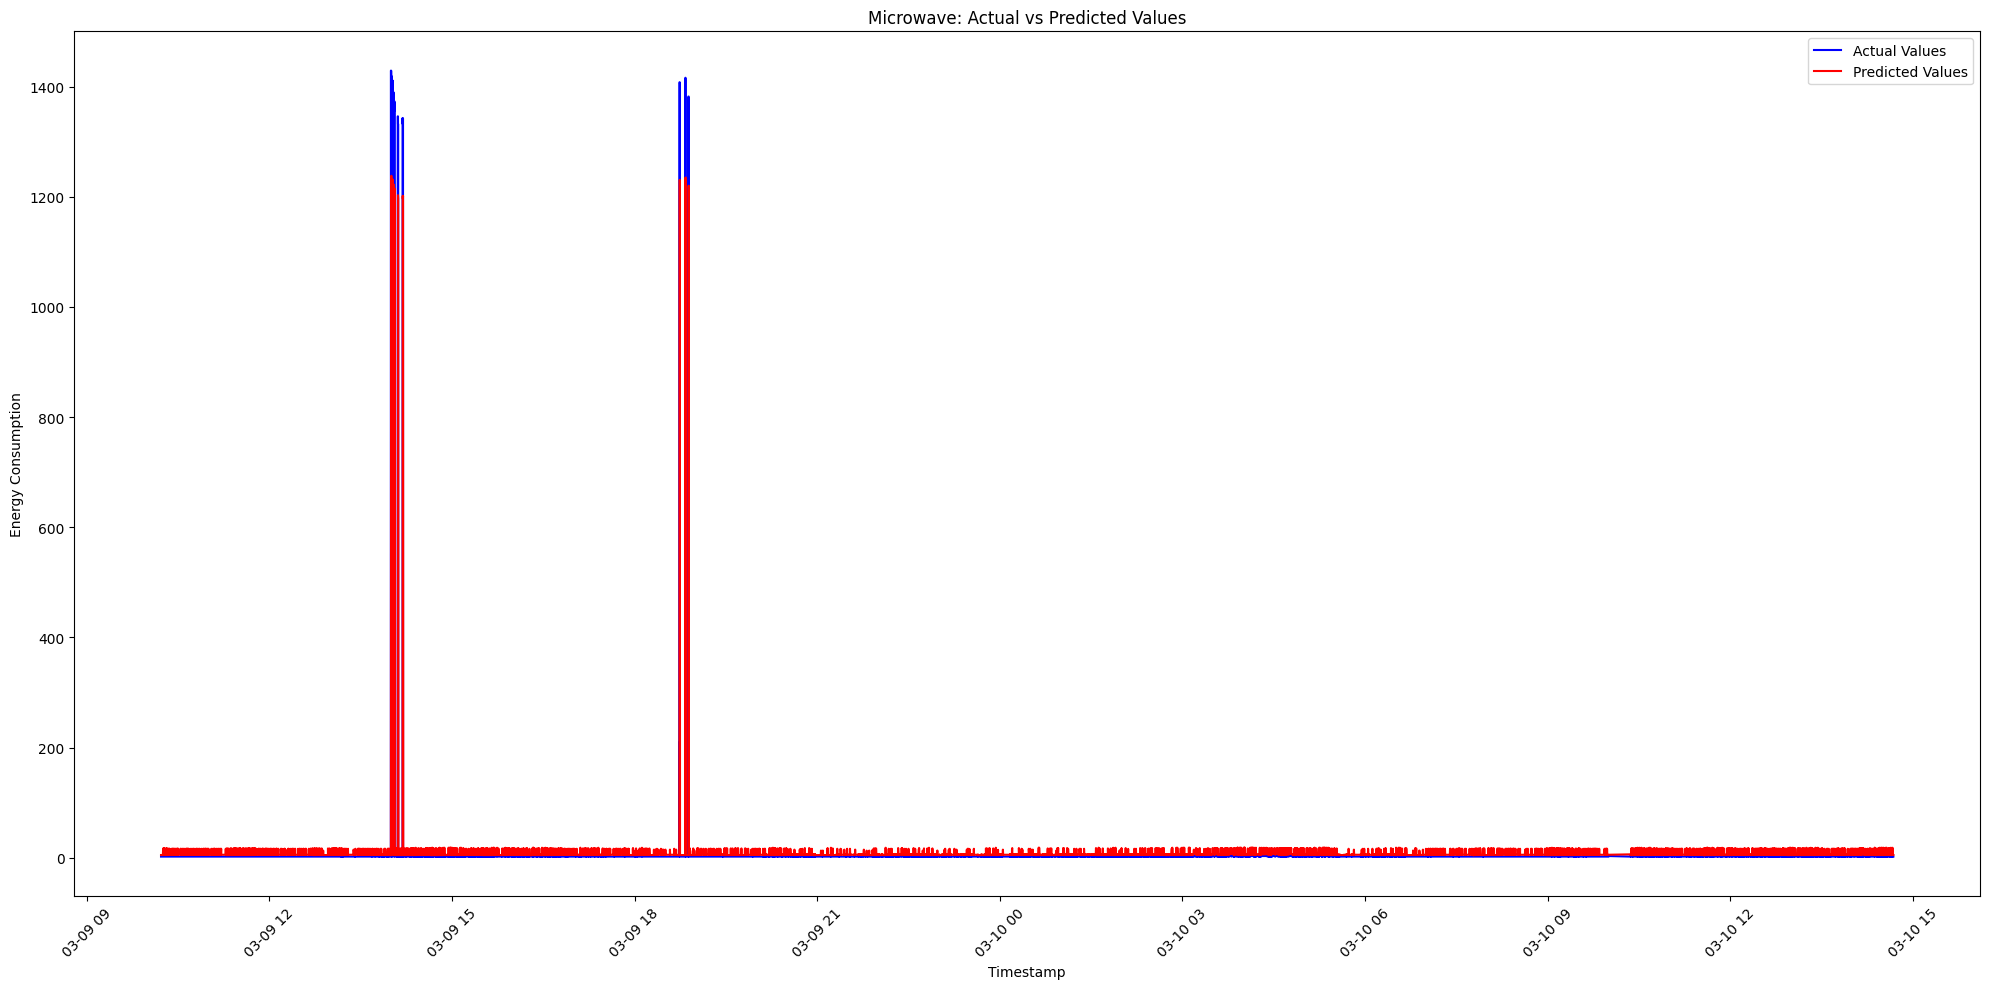

In [ ]:
# Plot actual and predicted values



plt.figure(figsize=(20, 10))
plt.plot(microwave_output['Timestamp'], microwave_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(microwave_output['Timestamp'], microwave_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Gated Recurrent Unit

In [ ]:
from keras.layers import GRU

# Define GRU model architecture
def build_gru_model(input_shape):
    model = Sequential([
        GRU(units=64, input_shape=input_shape),
        Dense(units=3)  # Assuming we're predicting 3 features
    ])
    return model

# Compile the model
model = build_gru_model(input_shape=(train_X[1].shape[1], train_X[1].shape[2]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                13248     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 13443 (52.51 KB)
Trainable params: 13443 (52.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(train_X[1], train_y[1], epochs=100, batch_size=32, validation_data=(test_X[1], test_y[1]))



Epoch 1/100
1220/1220 [==============================] - 8s 4ms/step - loss: 7.2067e-04 - accuracy: 0.9985 - val_loss: 0.0133 - val_accuracy: 0.9903
Epoch 2/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.2079e-04 - accuracy: 0.9988 - val_loss: 0.0134 - val_accuracy: 0.9903
Epoch 3/100
1220/1220 [==============================] - 4s 4ms/step - loss: 3.1722e-04 - accuracy: 0.9988 - val_loss: 0.0135 - val_accuracy: 0.9872
Epoch 4/100
1220/1220 [==============================] - 4s 4ms/step - loss: 3.1362e-04 - accuracy: 0.9988 - val_loss: 0.0132 - val_accuracy: 0.9903
Epoch 5/100
1220/1220 [==============================] - 4s 4ms/step - loss: 3.1479e-04 - accuracy: 0.9987 - val_loss: 0.0135 - val_accuracy: 0.9885
Epoch 6/100
1220/1220 [==============================] - 4s 4ms/step - loss: 3.1842e-04 - accuracy: 0.9988 - val_loss: 0.0132 - val_accuracy: 0.9885
Epoch 7/100
1220/1220 [==============================] - 4s 4ms/step - loss: 3.1823e-04 - accuracy: 0.9988

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(train_X[1], train_y[1])
print("Train Loss:", loss)
print("Train Accuracy:", accuracy)



1220/1220 [==============================] - 2s 1ms/step - loss: 2.9591e-04 - accuracy: 0.9988
Train Loss: 0.00029590699705295265
Train Accuracy: 0.9987958669662476


In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_X[1], test_y[1])
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



523/523 [==============================] - 1s 2ms/step - loss: 0.0127 - accuracy: 0.9872
Test Loss: 0.01273349393159151
Test Accuracy: 0.9872070550918579


In [ ]:
# Optionally, save the trained model
model.save('gru_model.h5')


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict energy consumption using the trained LSTM model
predictions = model.predict(test_X[1])

# Inverse transform predictions using the scaler
predictions = test_scalers[1].inverse_transform(predictions)

# Inverse transform the actual values to get the original scale of energy consumption
actual_values = test_scalers[1].inverse_transform(test_y[1])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


523/523 [==============================] - 2s 2ms/step
Mean Squared Error (MSE): 679.1009436918972
Root Mean Squared Error (RMSE): 26.059565301284234
Mean Absolute Error (MAE): 1.8021561340050674


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict energy consumption using the trained LSTM model
predictions = model.predict(test_X[1])

# Inverse transform predictions using the scaler
predictions = test_scalers[1].inverse_transform(predictions)

# Inverse transform the actual values to get the original scale of energy consumption
actual_values = test_y[1]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


523/523 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 2191.02598473642
Root Mean Squared Error (RMSE): 46.808396519603406
Mean Absolute Error (MAE): 19.468361032123664


In [ ]:
import matplotlib.pyplot as plt

# Fridge


timestamp_index = test_data[1].index[:len(predictions)]

fridge_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 0],
    'Predicted Values': predictions[:, 0]
})

#fridge_output = pd.concat([comparison_df], axis=1)
# Print the DataFrame
print("Fridge:")
print(fridge_output.head(20))
#print(fridge_output.head)


Fridge:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13           73.0         74.473267
1  2014-03-09 10:13:15           73.0         73.512009
2  2014-03-09 10:13:20           73.0         73.512009
3  2014-03-09 10:13:27           73.0         73.512009
4  2014-03-09 10:13:29           74.0         73.512009
5  2014-03-09 10:13:34           73.0         74.473267
6  2014-03-09 10:13:43           74.0         73.512009
7  2014-03-09 10:13:48           72.0         74.473267
8  2014-03-09 10:13:57           72.0         72.549774
9  2014-03-09 10:14:02           74.0         72.549774
10 2014-03-09 10:14:12           73.0         74.473267
11 2014-03-09 10:14:16           73.0         73.512009
12 2014-03-09 10:14:19           73.0         73.512009
13 2014-03-09 10:14:26           74.0         73.512009
14 2014-03-09 10:14:31           74.0         74.473267
15 2014-03-09 10:14:33           74.0         74.473267
16 2014-03-09 10:14:45           73.0   

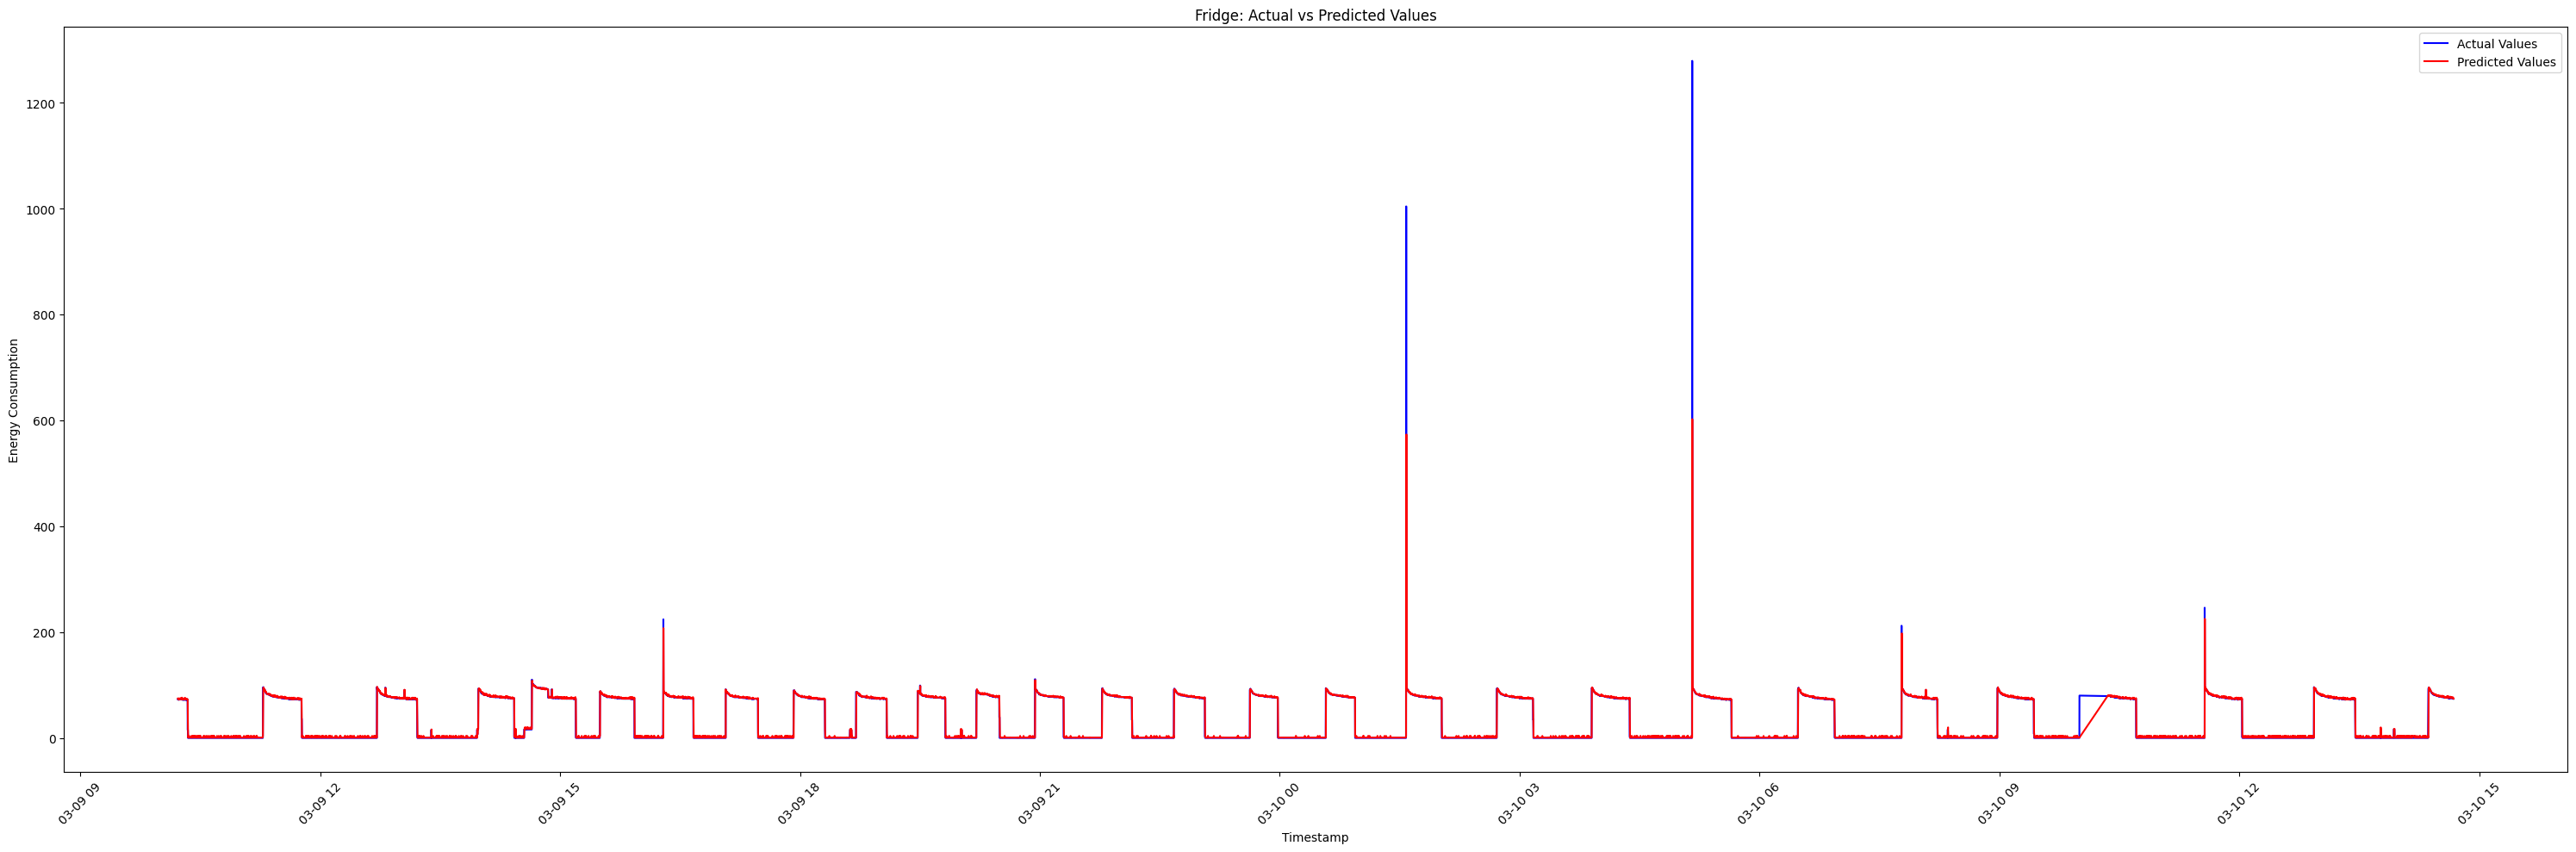

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(30, 10))
plt.plot(fridge_output['Timestamp'], fridge_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(fridge_output['Timestamp'], fridge_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Fridge: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Television

timestamp_index = test_data[1].index[:len(predictions)]


tv_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 1],
    'Predicted Values': predictions[:, 1]
})

#fridge_output = pd.concat([comparison_df], axis=1)
# Print the DataFrame
print("Television:")
print(tv_output.head(20))


Television:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13           21.0         21.021000
1  2014-03-09 10:13:15           21.0         21.021008
2  2014-03-09 10:13:20           21.0         21.021008
3  2014-03-09 10:13:27           21.0         21.021008
4  2014-03-09 10:13:29           21.0         21.021008
5  2014-03-09 10:13:34           21.0         21.021000
6  2014-03-09 10:13:43           21.0         21.021008
7  2014-03-09 10:13:48           21.0         21.021000
8  2014-03-09 10:13:57           21.0         21.021013
9  2014-03-09 10:14:02           21.0         21.021013
10 2014-03-09 10:14:12           21.0         21.021000
11 2014-03-09 10:14:16           21.0         21.021008
12 2014-03-09 10:14:19           21.0         21.021008
13 2014-03-09 10:14:26           21.0         21.021008
14 2014-03-09 10:14:31           21.0         21.021000
15 2014-03-09 10:14:33           21.0         21.021000
16 2014-03-09 10:14:45           21.

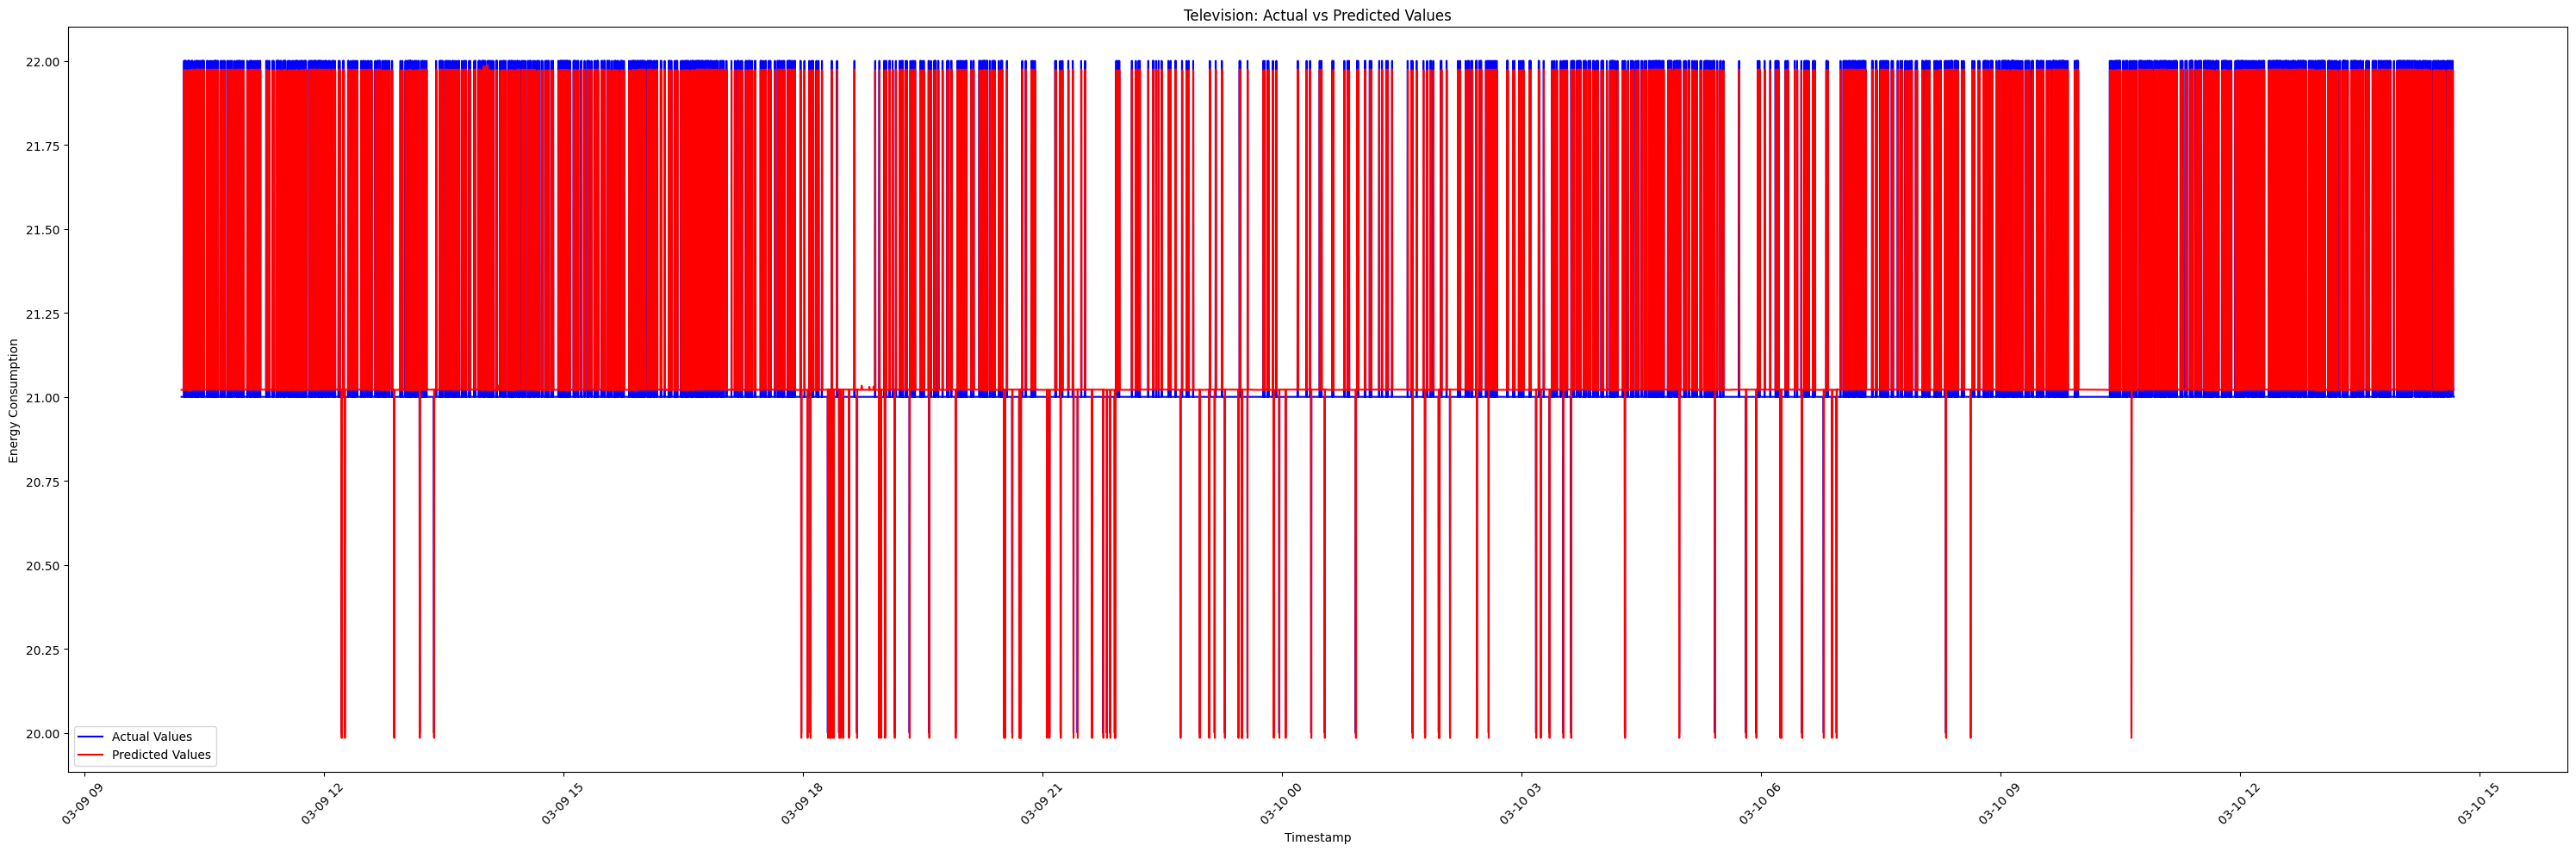

In [ ]:
import matplotlib.pyplot as plt

# Plot actual and predicted values
plt.figure(figsize=(30, 10))
plt.plot(tv_output['Timestamp'], tv_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(tv_output['Timestamp'], tv_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Television: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Extract the timestamp index from the test data
timestamp_index = test_data[1].index[:len(predictions)]

# Create DataFrame for Microwave predictions
microwave_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 2],
    'Predicted Values': predictions[:, 2]
})

# Print the DataFrame for the Microwave appliance
print("Microwave:")
print(microwave_output.head(20))


Microwave:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13            2.0          0.177955
1  2014-03-09 10:13:15            2.0          0.188869
2  2014-03-09 10:13:20            2.0          0.188869
3  2014-03-09 10:13:27            2.0          0.188869
4  2014-03-09 10:13:29            2.0          0.188869
5  2014-03-09 10:13:34            2.0          0.177955
6  2014-03-09 10:13:43            2.0          0.188869
7  2014-03-09 10:13:48            2.0          0.177955
8  2014-03-09 10:13:57            2.0          0.199836
9  2014-03-09 10:14:02            2.0          0.199836
10 2014-03-09 10:14:12            2.0          0.177955
11 2014-03-09 10:14:16            2.0          0.188869
12 2014-03-09 10:14:19            2.0          0.188869
13 2014-03-09 10:14:26            2.0          0.188869
14 2014-03-09 10:14:31            2.0          0.177955
15 2014-03-09 10:14:33            2.0          0.177955
16 2014-03-09 10:14:45            2.0

In [ ]:
# Extract the timestamp index from the test data
timestamp_index = test_data[1].index[:len(predictions)]

# Create DataFrame for Microwave predictions
microwave_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 2],
    'Predicted Values': predictions[:, 2]
})

# Print the DataFrame for the Microwave appliance
print("Microwave:")
print(microwave_output)


Microwave:
                Timestamp  Actual Values  Predicted Values
0     2014-03-09 10:13:13       0.000000          0.177955
1     2014-03-09 10:13:15       0.000000          0.188869
2     2014-03-09 10:13:20       0.000000          0.188869
3     2014-03-09 10:13:27       0.000000          0.188869
4     2014-03-09 10:13:29       0.000000          0.188869
...                   ...            ...               ...
16723 2014-03-10 14:40:18       0.000701          1.235789
16724 2014-03-10 14:40:29       0.000000          1.235789
16725 2014-03-10 14:40:32       0.000000          0.167042
16726 2014-03-10 14:40:33       0.000000          0.167042
16727 2014-03-10 14:40:46       0.000000          0.177955

[16728 rows x 3 columns]


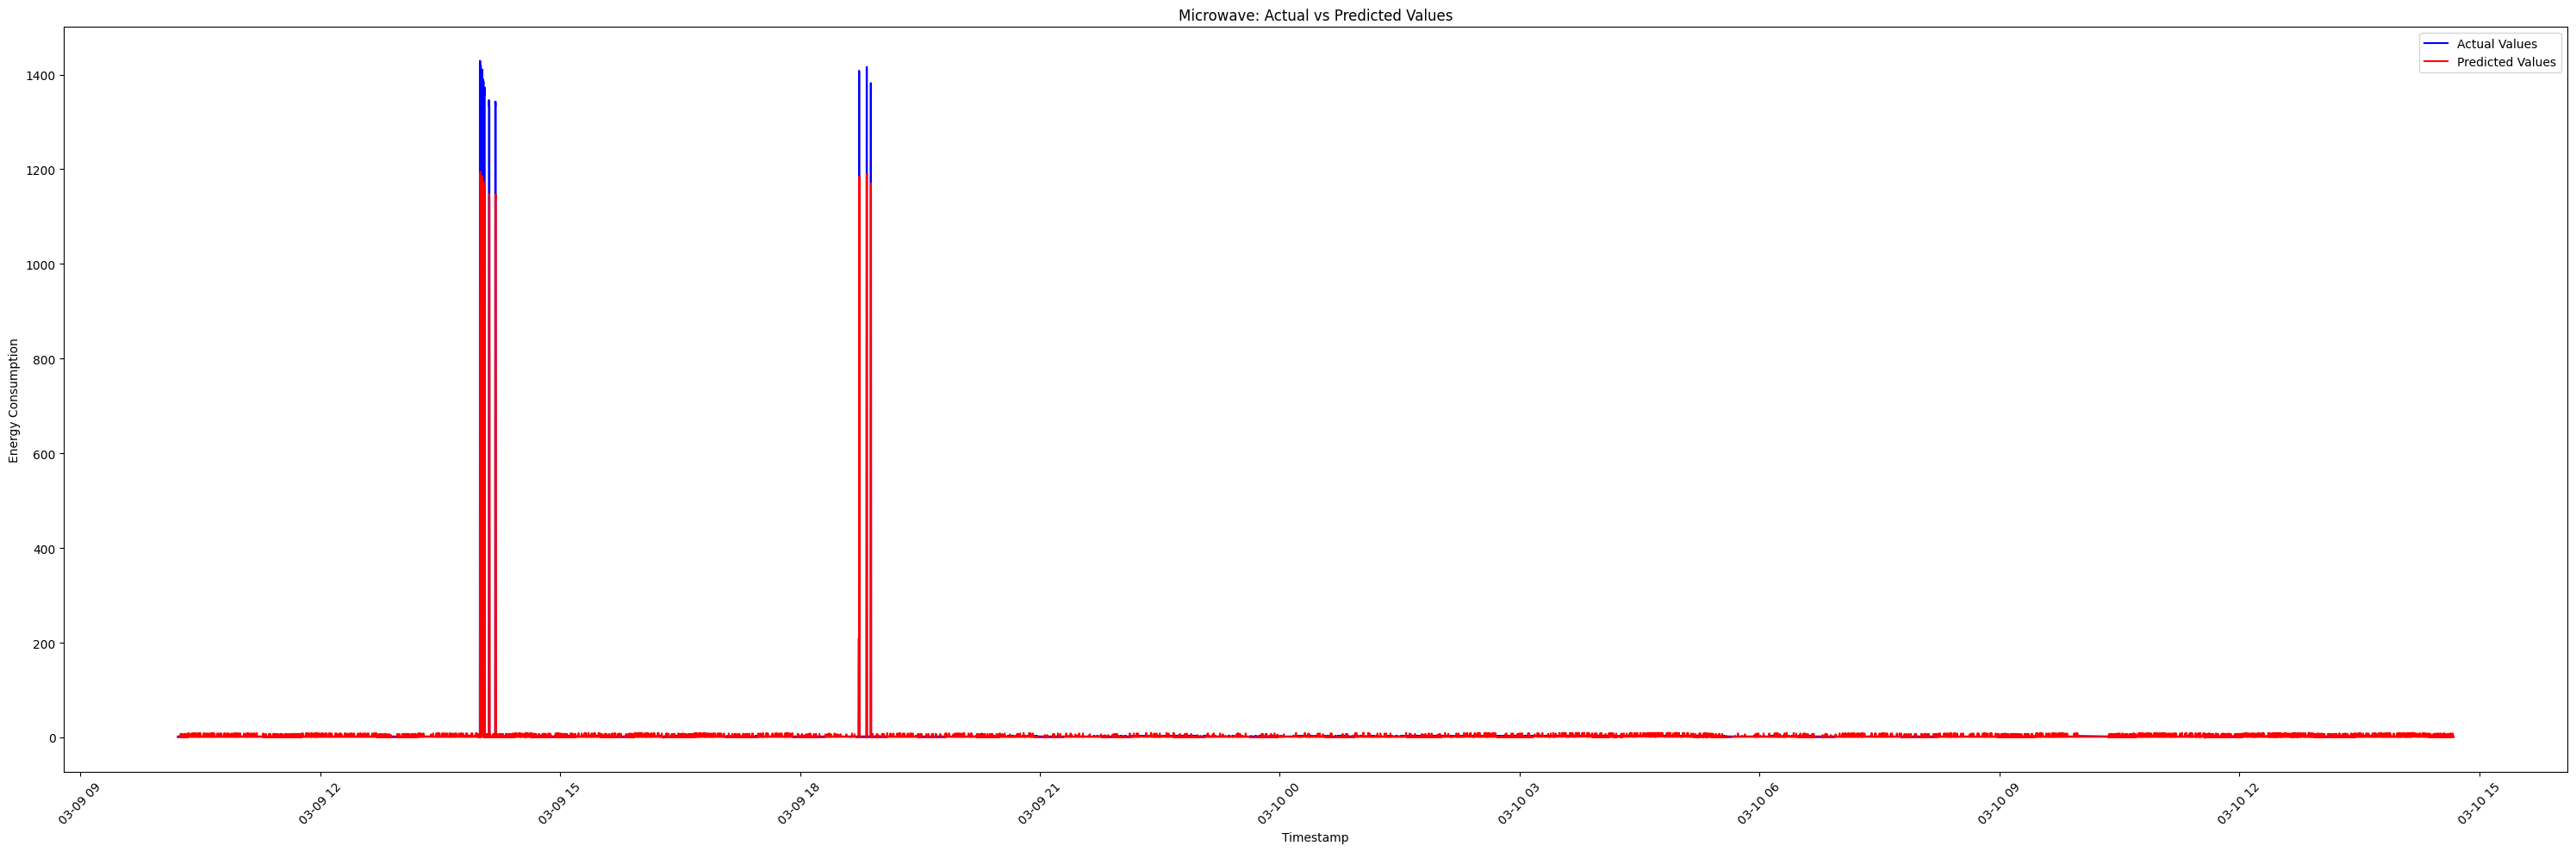

In [ ]:
import matplotlib.pyplot as plt

# Plot actual and predicted values
plt.figure(figsize=(30, 10))
plt.plot(microwave_output['Timestamp'], microwave_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(microwave_output['Timestamp'], microwave_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Inverse transform predictions using the scaler
predictions = test_scalers[1].inverse_transform(predictions)

# Create a DataFrame with Timestamp, Actual Values, and Predicted Values
df_output = pd.DataFrame({
     # Assuming test_data[1] contains the timestamp index
    'Actual Values': actual_values[:, 2],  # Assuming we're predicting energy consumption for the first appliance
    'Predicted Values': predictions[:, 2]  # Assuming we're predicting energy consumption for the first appliance
})

# Display the DataFrame
print("Fridge:")
print(df_output)


Fridge:
       Actual Values  Predicted Values
0                2.0      3.652316e+05
1                2.0      3.874555e+05
2                2.0      3.874555e+05
3                2.0      3.874555e+05
4                2.0      3.874555e+05
...              ...               ...
16723            3.0      2.519330e+06
16724            2.0      2.519330e+06
16725            2.0      3.430076e+05
16726            2.0      3.430076e+05
16727            2.0      3.652316e+05

[16728 rows x 2 columns]


## Model Deployment

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load the Vanilla LSTM model
model = load_model('lstm_model.h5')

# Define a function to prepare data for prediction
def prepare_data(df):

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler




def predict_energy_consumption(input_data, scaler, time):

    # Prepare the input data
    prepared_input = input_data.reshape((1, input_data.shape[0], input_data.shape[1]))


    # Predict energy consumption
    predictions = model.predict(prepared_input)


    # Inverse transform the predictions to get the original scale of energy consumption
    predictions = scaler.inverse_transform(predictions)


    # Calculate total energy consumption
    total_energy_consumption = np.sum(predictions) * time

    # Calculate cost - rate = 12

    cost = total_energy_consumption * 12

    # Calculate time in hours
    time_hours = time

    return predictions, total_energy_consumption, cost, time_hours




# Streamlit app
def main():
    st.title('Smart Energy Management App')


    st.write('Enter Appliance Data:')

    # Input fields for each appliance
    appliance_data = []
    for i in range(3):
        st.write('## Appliance {}:'.format(i+1))
        energy_consumption = st.number_input('Energy Consumption (kWh) for Appliance {}'.format(i+1), min_value=0.0, step=0.01)
        appliance_data.append(energy_consumption)




    time = st.number_input('Enter Time (in hour)', min_value=0, step=1)


    input_data = np.array([appliance_data])
    scaled_input_data, scaler = prepare_data(input_data)



    # Button to trigger prediction
    if st.button('Predict Energy Consumption'):


        predictions, total_energy_consumption, cost, time_hours = predict_energy_consumption(scaled_input_data, scaler, time)

        # Display the predictions
        st.write("## Energy Consumption Prediction:")
        for i, pred in enumerate(predictions[0]):
            st.write("Appliance {}: {} kWh".format(i+1, pred))

        st.write("Total Energy Consumption: {:.2f} kWh".format(total_energy_consumption))
        st.write("Time: {:.2f} hours".format(time_hours))
        st.write("Cost: PHP{:.2f}".format(cost))


if __name__ == "__main__":
    main()
